In [1]:
from dataloader import *
from models import CustomUnet
from train import train_all
import torch.nn as nn
from loss import WeightedBinaryCrossEntropyLoss
import matplotlib.pyplot as plt

In [2]:
val_dataloader = getDataloader(mode='val')

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [3]:
train_dataloader = getDataloader(mode='train', augment=True)

loading annotations into memory...
Done (t=17.20s)
creating index...
index created!


In [4]:
model = CustomUnet
model = model()
n_epochs = 50

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(f"Device used :{device}")

Device used :cuda


In [ ]:
trained_model = train_all(model, n_epochs, train_dataloader)

EPOCH 1:


101it [00:14,  7.43it/s]

  batch 100 loss: 0.7005518785119057


201it [00:28,  7.31it/s]

  batch 200 loss: 0.6001220828294754


301it [00:41,  7.18it/s]

  batch 300 loss: 0.5871671169996262


401it [00:56,  7.02it/s]

  batch 400 loss: 0.5476138785481452


501it [01:10,  6.97it/s]

  batch 500 loss: 0.5595301029086113


601it [01:24,  6.88it/s]

  batch 600 loss: 0.5526562750339508


701it [01:39,  6.77it/s]

  batch 700 loss: 0.5592850136756897


801it [01:54,  6.80it/s]

  batch 800 loss: 0.4995720812678337


901it [02:09,  6.67it/s]

  batch 900 loss: 0.5305493900179863


1001it [02:24,  6.62it/s]

  batch 1000 loss: 0.7915682977437973


1101it [02:39,  6.58it/s]

  batch 1100 loss: 0.7037607342004776


1201it [02:54,  6.58it/s]

  batch 1200 loss: 0.6861733382940293


1301it [03:09,  6.55it/s]

  batch 1300 loss: 0.6298290771245957


1401it [03:24,  6.62it/s]

  batch 1400 loss: 0.6527835127711296


1501it [03:40,  6.55it/s]

  batch 1500 loss: 0.6689714601635933


1601it [03:55,  6.65it/s]

  batch 1600 loss: 0.6137461867928505


1701it [04:10,  6.68it/s]

  batch 1700 loss: 0.6696512749791146


1801it [04:25,  6.66it/s]

  batch 1800 loss: 0.6615971201658248


1901it [04:40,  6.69it/s]

  batch 1900 loss: 0.6831157055497169


2001it [04:55,  6.71it/s]

  batch 2000 loss: 0.5807803875207901


2101it [05:10,  6.67it/s]

  batch 2100 loss: 0.5873688238859177


2201it [05:25,  6.69it/s]

  batch 2200 loss: 0.6450539949536324


2301it [05:40,  6.67it/s]

  batch 2300 loss: 0.597901681959629


2401it [05:55,  6.68it/s]

  batch 2400 loss: 0.611116007566452


2501it [06:09,  6.72it/s]

  batch 2500 loss: 0.60005529910326


2601it [06:24,  6.74it/s]

  batch 2600 loss: 0.6534992066025734


2701it [06:39,  6.68it/s]

  batch 2700 loss: 0.6009333893656731


2801it [06:54,  6.76it/s]

  batch 2800 loss: 0.6500617456436157


2901it [07:09,  6.74it/s]

  batch 2900 loss: 0.6658965620398521


3001it [07:24,  6.78it/s]

  batch 3000 loss: 0.6014209923148155


3101it [07:38,  6.71it/s]

  batch 3100 loss: 0.5977399191260337


3201it [07:53,  6.71it/s]

  batch 3200 loss: 0.611555143892765


3301it [08:08,  6.75it/s]

  batch 3300 loss: 0.5887509772181511


3401it [08:23,  6.82it/s]

  batch 3400 loss: 0.6006970781087876


3501it [08:38,  6.81it/s]

  batch 3500 loss: 0.6255694663524628


3588it [08:51,  6.75it/s]


LOSS train 0.6194024404953156
EPOCH 2:


101it [00:14,  6.51it/s]

  batch 100 loss: 0.5716639515757561


201it [00:29,  6.72it/s]

  batch 200 loss: 0.5190928548574447


301it [00:44,  6.75it/s]

  batch 300 loss: 0.5106050768494605


401it [00:59,  6.71it/s]

  batch 400 loss: 0.4801658409833908


501it [01:13,  6.77it/s]

  batch 500 loss: 0.48741581559181213


601it [01:28,  6.81it/s]

  batch 600 loss: 0.4948124100267887


701it [01:43,  6.76it/s]

  batch 700 loss: 0.5107497385144234


801it [01:58,  6.83it/s]

  batch 800 loss: 0.4497860485315323


901it [02:12,  6.80it/s]

  batch 900 loss: 0.4710676658153534


1001it [02:27,  6.84it/s]

  batch 1000 loss: 0.7146052575111389


1101it [02:42,  6.82it/s]

  batch 1100 loss: 0.6509336054325103


1201it [02:56,  6.86it/s]

  batch 1200 loss: 0.6289244666695595


1301it [03:11,  6.85it/s]

  batch 1300 loss: 0.56621183604002


1401it [03:26,  6.86it/s]

  batch 1400 loss: 0.6067942395806313


1501it [03:41,  6.82it/s]

  batch 1500 loss: 0.6243498167395591


1601it [03:55,  6.82it/s]

  batch 1600 loss: 0.5708253368735313


1701it [04:10,  6.83it/s]

  batch 1700 loss: 0.6247010436654091


1801it [04:25,  6.85it/s]

  batch 1800 loss: 0.6299097368121147


1901it [04:39,  6.73it/s]

  batch 1900 loss: 0.6404861283302307


2001it [04:54,  6.79it/s]

  batch 2000 loss: 0.5341437694430351


2101it [05:09,  6.78it/s]

  batch 2100 loss: 0.5522757679224014


2201it [05:24,  6.81it/s]

  batch 2200 loss: 0.6011542257666588


2301it [05:38,  6.79it/s]

  batch 2300 loss: 0.5672023203969002


2401it [05:53,  6.77it/s]

  batch 2400 loss: 0.5768833070993423


2501it [06:08,  6.81it/s]

  batch 2500 loss: 0.5724642363190651


2601it [06:23,  6.80it/s]

  batch 2600 loss: 0.62398929387331


2701it [06:37,  6.79it/s]

  batch 2700 loss: 0.5654349967837333


2801it [06:52,  6.78it/s]

  batch 2800 loss: 0.6200891143083572


2901it [07:07,  6.79it/s]

  batch 2900 loss: 0.6309682947397232


3001it [07:22,  6.79it/s]

  batch 3000 loss: 0.5694866964221


3101it [07:36,  6.75it/s]

  batch 3100 loss: 0.5760121709108352


3201it [07:51,  6.79it/s]

  batch 3200 loss: 0.5782020118832588


3301it [08:06,  6.77it/s]

  batch 3300 loss: 0.5651458787918091


3401it [08:20,  6.75it/s]

  batch 3400 loss: 0.5710130080580711


3501it [08:35,  6.76it/s]

  batch 3500 loss: 0.5954368400573731


3588it [08:48,  6.79it/s]


LOSS train 0.5720435831832846
EPOCH 3:


101it [00:14,  6.77it/s]

  batch 100 loss: 0.519325984120369


201it [00:29,  6.77it/s]

  batch 200 loss: 0.46470593750476835


301it [00:44,  6.82it/s]

  batch 300 loss: 0.4736517471075058


401it [00:59,  6.78it/s]

  batch 400 loss: 0.43417638435959816


501it [01:13,  6.79it/s]

  batch 500 loss: 0.4487091773748398


601it [01:28,  6.78it/s]

  batch 600 loss: 0.449069100022316


701it [01:43,  6.79it/s]

  batch 700 loss: 0.4705703017115593


801it [01:58,  6.74it/s]

  batch 800 loss: 0.4142580853402615


901it [02:13,  6.77it/s]

  batch 900 loss: 0.43602065697312353


1001it [02:27,  6.79it/s]

  batch 1000 loss: 0.706920070052147


1101it [02:42,  6.76it/s]

  batch 1100 loss: 0.6156537202000618


1201it [02:57,  6.82it/s]

  batch 1200 loss: 0.5983785650134087


1301it [03:12,  6.75it/s]

  batch 1300 loss: 0.5277014148235321


1401it [03:26,  6.80it/s]

  batch 1400 loss: 0.5819825294613838


1501it [03:41,  6.80it/s]

  batch 1500 loss: 0.5926801463961602


1601it [03:56,  6.79it/s]

  batch 1600 loss: 0.5476527288556099


1701it [04:11,  6.81it/s]

  batch 1700 loss: 0.591637886762619


1801it [04:25,  6.80it/s]

  batch 1800 loss: 0.6102773225307465


1901it [04:40,  6.76it/s]

  batch 1900 loss: 0.604295357465744


2001it [04:55,  6.74it/s]

  batch 2000 loss: 0.5069777598977089


2101it [05:10,  6.74it/s]

  batch 2100 loss: 0.5218204735219478


2201it [05:25,  6.75it/s]

  batch 2200 loss: 0.5835869362950326


2301it [05:39,  6.79it/s]

  batch 2300 loss: 0.5381356462836265


2401it [05:54,  6.81it/s]

  batch 2400 loss: 0.5480061618983746


2501it [06:09,  6.60it/s]

  batch 2500 loss: 0.5415767496824264


2601it [06:24,  6.76it/s]

  batch 2600 loss: 0.6031272199749946


2701it [06:39,  6.82it/s]

  batch 2700 loss: 0.5381207683682442


2801it [06:53,  6.79it/s]

  batch 2800 loss: 0.5894232013821602


2901it [07:08,  6.77it/s]

  batch 2900 loss: 0.59804108440876


3001it [07:23,  6.78it/s]

  batch 3000 loss: 0.5389971935749054


3101it [07:38,  6.74it/s]

  batch 3100 loss: 0.5510829284787178


3201it [07:53,  6.75it/s]

  batch 3200 loss: 0.5327463924884797


3301it [08:07,  6.75it/s]

  batch 3300 loss: 0.5488675460219383


3401it [08:22,  6.76it/s]

  batch 3400 loss: 0.5318829387426376


3501it [08:37,  6.76it/s]

  batch 3500 loss: 0.5589091265201569


3588it [08:50,  6.76it/s]


LOSS train 0.5396116791187122
EPOCH 4:


101it [00:14,  6.73it/s]

  batch 100 loss: 0.47883814096450805


201it [00:29,  6.75it/s]

  batch 200 loss: 0.4260017953813076


301it [00:44,  6.79it/s]

  batch 300 loss: 0.4308443793654442


401it [00:59,  6.79it/s]

  batch 400 loss: 0.3924958829581737


501it [01:14,  6.78it/s]

  batch 500 loss: 0.41021677762269976


601it [01:28,  6.84it/s]

  batch 600 loss: 0.4015760385990143


701it [01:43,  6.74it/s]

  batch 700 loss: 0.41909412369132043


801it [01:58,  6.73it/s]

  batch 800 loss: 0.3857474599778652


901it [02:13,  6.76it/s]

  batch 900 loss: 0.4019751703739166


1001it [02:27,  6.80it/s]

  batch 1000 loss: 0.6646669232845306


1101it [02:42,  6.75it/s]

  batch 1100 loss: 0.5747129991650581


1201it [02:57,  6.80it/s]

  batch 1200 loss: 0.5609602478146553


1301it [03:12,  6.76it/s]

  batch 1300 loss: 0.5002245737612248


1401it [03:27,  6.76it/s]

  batch 1400 loss: 0.5465373235940933


1501it [03:41,  6.74it/s]

  batch 1500 loss: 0.5694621121883392


1601it [03:56,  6.81it/s]

  batch 1600 loss: 0.49851853772997856


1701it [04:11,  6.77it/s]

  batch 1700 loss: 0.5484188912808895


1801it [04:26,  6.79it/s]

  batch 1800 loss: 0.5629221189022064


1901it [04:41,  6.75it/s]

  batch 1900 loss: 0.5793694986402989


2001it [04:55,  6.80it/s]

  batch 2000 loss: 0.4761176574230194


2101it [05:10,  6.73it/s]

  batch 2100 loss: 0.4951520282030106


2201it [05:25,  6.78it/s]

  batch 2200 loss: 0.5529570500552654


2301it [05:40,  6.76it/s]

  batch 2300 loss: 0.4973632153868675


2401it [05:55,  6.78it/s]

  batch 2400 loss: 0.5003876209259033


2501it [06:09,  6.78it/s]

  batch 2500 loss: 0.5034708990156651


2601it [06:24,  6.74it/s]

  batch 2600 loss: 0.5706797067821026


2701it [06:39,  6.74it/s]

  batch 2700 loss: 0.5142643564939499


2801it [06:53,  6.79it/s]

  batch 2800 loss: 0.5530363307893276


2901it [07:08,  6.79it/s]

  batch 2900 loss: 0.5596253415942192


3001it [07:23,  6.77it/s]

  batch 3000 loss: 0.5086701688170433


3101it [07:38,  6.81it/s]

  batch 3100 loss: 0.5196600413322449


3201it [07:52,  6.82it/s]

  batch 3200 loss: 0.4841461980342865


3301it [08:07,  6.81it/s]

  batch 3300 loss: 0.5212862391769886


3401it [08:22,  6.80it/s]

  batch 3400 loss: 0.4988424353301525


3501it [08:37,  6.82it/s]

  batch 3500 loss: 0.5153026261925697


3588it [08:49,  6.77it/s]


LOSS train 0.5025915830098134
EPOCH 5:


101it [00:14,  6.79it/s]

  batch 100 loss: 0.44389880165457724


201it [00:29,  6.75it/s]

  batch 200 loss: 0.3873597903549671


301it [00:44,  6.72it/s]

  batch 300 loss: 0.3962734889984131


401it [00:59,  6.78it/s]

  batch 400 loss: 0.36124691292643546


501it [01:13,  6.79it/s]

  batch 500 loss: 0.3765528133511543


601it [01:28,  6.80it/s]

  batch 600 loss: 0.36757644489407537


701it [01:43,  6.80it/s]

  batch 700 loss: 0.3817122659087181


801it [01:58,  6.77it/s]

  batch 800 loss: 0.3637376399338245


901it [02:12,  6.81it/s]

  batch 900 loss: 0.3728514455258846


1001it [02:27,  6.82it/s]

  batch 1000 loss: 0.6122209657728672


1101it [02:42,  6.83it/s]

  batch 1100 loss: 0.5450509279966355


1201it [02:56,  6.84it/s]

  batch 1200 loss: 0.5254161857068539


1301it [03:11,  6.79it/s]

  batch 1300 loss: 0.47143527179956435


1401it [03:26,  6.88it/s]

  batch 1400 loss: 0.5115550185739994


1501it [03:40,  6.82it/s]

  batch 1500 loss: 0.5439944277703762


1601it [03:55,  6.85it/s]

  batch 1600 loss: 0.46893080085515976


1701it [04:10,  6.80it/s]

  batch 1700 loss: 0.5087981730699539


1801it [04:25,  6.79it/s]

  batch 1800 loss: 0.516343524158001


1901it [04:39,  6.78it/s]

  batch 1900 loss: 0.5368970768153667


2001it [04:54,  6.78it/s]

  batch 2000 loss: 0.45046366259455684


2101it [05:09,  6.82it/s]

  batch 2100 loss: 0.462043087631464


2201it [05:24,  6.79it/s]

  batch 2200 loss: 0.5156770415604115


2301it [05:38,  6.76it/s]

  batch 2300 loss: 0.4652172681689262


2401it [05:53,  6.80it/s]

  batch 2400 loss: 0.4595321710407734


2501it [06:08,  6.78it/s]

  batch 2500 loss: 0.46876808822155


2601it [06:23,  6.79it/s]

  batch 2600 loss: 0.5274322986602783


2701it [06:37,  6.76it/s]

  batch 2700 loss: 0.48605881452560423


2801it [06:52,  6.81it/s]

  batch 2800 loss: 0.528636290282011


2901it [07:07,  6.79it/s]

  batch 2900 loss: 0.5138047887384891


3001it [07:22,  6.79it/s]

  batch 3000 loss: 0.4813681647181511


3101it [07:36,  6.81it/s]

  batch 3100 loss: 0.48394087627530097


3201it [07:51,  6.78it/s]

  batch 3200 loss: 0.45526560351252554


3301it [08:06,  6.78it/s]

  batch 3300 loss: 0.4909694105386734


3401it [08:21,  6.76it/s]

  batch 3400 loss: 0.45563752502202987


3501it [08:35,  6.79it/s]

  batch 3500 loss: 0.46956201165914535


3588it [08:48,  6.79it/s]


LOSS train 0.46808713825716486
EPOCH 6:


101it [00:14,  6.78it/s]

  batch 100 loss: 0.4142666746675968


201it [00:29,  6.80it/s]

  batch 200 loss: 0.3596143968403339


301it [00:44,  6.76it/s]

  batch 300 loss: 0.36098569706082345


401it [00:59,  6.80it/s]

  batch 400 loss: 0.3298096300661564


501it [01:13,  6.80it/s]

  batch 500 loss: 0.3551935814321041


601it [01:28,  6.77it/s]

  batch 600 loss: 0.3366008570045233


701it [01:43,  6.74it/s]

  batch 700 loss: 0.35554691910743713


801it [01:58,  6.71it/s]

  batch 800 loss: 0.3445947328209877


901it [02:13,  6.81it/s]

  batch 900 loss: 0.34490814730525016


1001it [02:27,  6.75it/s]

  batch 1000 loss: 0.5616049258410931


1101it [02:42,  6.76it/s]

  batch 1100 loss: 0.5093488362431526


1201it [02:57,  6.76it/s]

  batch 1200 loss: 0.49494399353861807


1301it [03:12,  6.72it/s]

  batch 1300 loss: 0.44926659494638443


1401it [03:27,  6.72it/s]

  batch 1400 loss: 0.4880203787982464


1501it [03:41,  6.73it/s]

  batch 1500 loss: 0.5059866835176945


1601it [03:56,  6.73it/s]

  batch 1600 loss: 0.42986545264720916


1701it [04:11,  6.77it/s]

  batch 1700 loss: 0.4766250897943973


1801it [04:26,  6.74it/s]

  batch 1800 loss: 0.4853343287110329


1901it [04:41,  6.72it/s]

  batch 1900 loss: 0.503453943580389


2001it [04:55,  6.78it/s]

  batch 2000 loss: 0.4118001838028431


2101it [05:10,  6.75it/s]

  batch 2100 loss: 0.43079912081360816


2201it [05:25,  6.70it/s]

  batch 2200 loss: 0.4789388428628445


2301it [05:40,  6.78it/s]

  batch 2300 loss: 0.4536990286409855


2401it [05:55,  6.75it/s]

  batch 2400 loss: 0.432291771620512


2501it [06:10,  6.76it/s]

  batch 2500 loss: 0.440722384005785


2601it [06:25,  6.76it/s]

  batch 2600 loss: 0.4866759665310383


2701it [06:39,  6.72it/s]

  batch 2700 loss: 0.45598508447408675


2801it [06:54,  6.79it/s]

  batch 2800 loss: 0.501207662075758


2901it [07:09,  6.77it/s]

  batch 2900 loss: 0.4768153865635395


3001it [07:24,  6.73it/s]

  batch 3000 loss: 0.4580244220793247


3101it [07:39,  6.74it/s]

  batch 3100 loss: 0.45457477286458015


3201it [07:54,  6.71it/s]

  batch 3200 loss: 0.43370381951332093


3301it [08:08,  6.72it/s]

  batch 3300 loss: 0.46571754589676856


3401it [08:23,  6.78it/s]

  batch 3400 loss: 0.42728128492832185


3501it [08:38,  6.74it/s]

  batch 3500 loss: 0.43901082515716555


3588it [08:51,  6.75it/s]


LOSS train 0.43798555022390057
EPOCH 7:


101it [00:14,  6.74it/s]

  batch 100 loss: 0.38147102639079095


201it [00:29,  6.71it/s]

  batch 200 loss: 0.338158428221941


301it [00:44,  6.77it/s]

  batch 300 loss: 0.3353510503470898


401it [00:59,  6.75it/s]

  batch 400 loss: 0.3006645947694778


501it [01:14,  6.80it/s]

  batch 500 loss: 0.3363376732170582


601it [01:29,  6.77it/s]

  batch 600 loss: 0.3132177271693945


701it [01:43,  6.75it/s]

  batch 700 loss: 0.33286567613482476


801it [01:58,  6.75it/s]

  batch 800 loss: 0.3265145042538643


901it [02:13,  6.78it/s]

  batch 900 loss: 0.3217416663467884


1001it [02:28,  6.77it/s]

  batch 1000 loss: 0.5230030140280724


1101it [02:43,  6.79it/s]

  batch 1100 loss: 0.47585865363478663


1201it [02:57,  6.75it/s]

  batch 1200 loss: 0.462499181330204


1301it [03:12,  6.77it/s]

  batch 1300 loss: 0.4246403782069683


1401it [03:27,  6.74it/s]

  batch 1400 loss: 0.45527640521526336


1501it [03:42,  6.79it/s]

  batch 1500 loss: 0.4745922920107841


1601it [03:57,  6.79it/s]

  batch 1600 loss: 0.4024150752276182


1701it [04:11,  6.76it/s]

  batch 1700 loss: 0.4491393469274044


1801it [04:26,  6.78it/s]

  batch 1800 loss: 0.45142105981707575


1901it [04:41,  6.79it/s]

  batch 1900 loss: 0.46353203296661377


2001it [04:56,  6.77it/s]

  batch 2000 loss: 0.3797942893207073


2101it [05:11,  6.75it/s]

  batch 2100 loss: 0.40229337744414806


2201it [05:25,  6.77it/s]

  batch 2200 loss: 0.43952427461743354


2301it [05:40,  6.76it/s]

  batch 2300 loss: 0.42693318173289296


2401it [05:55,  6.80it/s]

  batch 2400 loss: 0.40087939739227296


2501it [06:10,  6.78it/s]

  batch 2500 loss: 0.41553029909729955


2601it [06:24,  6.79it/s]

  batch 2600 loss: 0.44755208998918533


2701it [06:39,  6.78it/s]

  batch 2700 loss: 0.41563378006219864


2801it [06:54,  6.76it/s]

  batch 2800 loss: 0.49546869590878484


2901it [07:09,  6.78it/s]

  batch 2900 loss: 0.4482604741305113


3001it [07:23,  6.76it/s]

  batch 3000 loss: 0.428517779558897


3101it [07:38,  6.74it/s]

  batch 3100 loss: 0.43951429560780525


3201it [07:53,  6.76it/s]

  batch 3200 loss: 0.4169682595133781


3301it [08:08,  6.76it/s]

  batch 3300 loss: 0.42942190006375314


3401it [08:23,  6.78it/s]

  batch 3400 loss: 0.3932892706990242


3501it [08:37,  6.79it/s]

  batch 3500 loss: 0.4085937039554119


3588it [08:50,  6.76it/s]


LOSS train 0.40982643192179224
EPOCH 8:


101it [00:14,  6.77it/s]

  batch 100 loss: 0.35346427679061887


201it [00:29,  6.79it/s]

  batch 200 loss: 0.32268499113619326


301it [00:44,  6.80it/s]

  batch 300 loss: 0.314841990545392


401it [00:59,  6.78it/s]

  batch 400 loss: 0.280626170784235


501it [01:13,  6.74it/s]

  batch 500 loss: 0.3163137239962816


601it [01:28,  6.81it/s]

  batch 600 loss: 0.2950645323842764


701it [01:43,  6.80it/s]

  batch 700 loss: 0.31383207261562346


801it [01:58,  6.81it/s]

  batch 800 loss: 0.3074432695657015


901it [02:12,  6.78it/s]

  batch 900 loss: 0.2990744209289551


1001it [02:27,  6.81it/s]

  batch 1000 loss: 0.47233442902565004


1101it [02:42,  6.73it/s]

  batch 1100 loss: 0.4356888223439455


1201it [02:57,  6.77it/s]

  batch 1200 loss: 0.43727383226156236


1301it [03:11,  6.80it/s]

  batch 1300 loss: 0.4162221619486809


1401it [03:26,  6.79it/s]

  batch 1400 loss: 0.42894638821482656


1501it [03:41,  6.80it/s]

  batch 1500 loss: 0.4534204024076462


1601it [03:56,  6.74it/s]

  batch 1600 loss: 0.3799036392569542


1701it [04:10,  6.74it/s]

  batch 1700 loss: 0.4201096364110708


1801it [04:25,  6.77it/s]

  batch 1800 loss: 0.42488326340913773


1901it [04:40,  6.76it/s]

  batch 1900 loss: 0.43780457235872744


2001it [04:55,  6.81it/s]

  batch 2000 loss: 0.3548505599796772


2101it [05:09,  6.82it/s]

  batch 2100 loss: 0.369655878841877


2201it [05:24,  6.76it/s]

  batch 2200 loss: 0.41160909965634346


2301it [05:39,  6.74it/s]

  batch 2300 loss: 0.4011158937215805


2401it [05:54,  6.82it/s]

  batch 2400 loss: 0.38149757400155065


2501it [06:09,  6.78it/s]

  batch 2500 loss: 0.4001427781581879


2601it [06:23,  6.77it/s]

  batch 2600 loss: 0.4143249435722828


2701it [06:38,  6.77it/s]

  batch 2700 loss: 0.3799230669438839


2801it [06:53,  6.78it/s]

  batch 2800 loss: 0.44572535291314125


2901it [07:08,  6.81it/s]

  batch 2900 loss: 0.4128989239782095


3001it [07:22,  6.76it/s]

  batch 3000 loss: 0.3947217628359795


3101it [07:37,  6.78it/s]

  batch 3100 loss: 0.4136167404055595


3201it [07:52,  6.78it/s]

  batch 3200 loss: 0.4162044154107571


3301it [08:07,  6.78it/s]

  batch 3300 loss: 0.4111553690582514


3401it [08:21,  6.78it/s]

  batch 3400 loss: 0.3693130595982075


3501it [08:36,  6.79it/s]

  batch 3500 loss: 0.3794835563004017


3588it [08:49,  6.77it/s]


LOSS train 0.38439603435205777
EPOCH 9:


101it [00:14,  6.73it/s]

  batch 100 loss: 0.3281189539283514


201it [00:29,  6.76it/s]

  batch 200 loss: 0.30599842347204687


301it [00:44,  6.78it/s]

  batch 300 loss: 0.29458728596568107


401it [00:59,  6.81it/s]

  batch 400 loss: 0.26179310664534566


501it [01:13,  6.77it/s]

  batch 500 loss: 0.29639760628342626


601it [01:28,  6.81it/s]

  batch 600 loss: 0.2768194478750229


701it [01:43,  6.85it/s]

  batch 700 loss: 0.2936911760270596


801it [01:57,  6.81it/s]

  batch 800 loss: 0.28629899106919765


901it [02:12,  6.83it/s]

  batch 900 loss: 0.27865798644721507


1001it [02:27,  6.80it/s]

  batch 1000 loss: 0.42430836834013463


1101it [02:42,  6.77it/s]

  batch 1100 loss: 0.40749149546027186


1201it [02:56,  6.83it/s]

  batch 1200 loss: 0.4081903699785471


1301it [03:11,  6.78it/s]

  batch 1300 loss: 0.3875077809393406


1401it [03:26,  6.72it/s]

  batch 1400 loss: 0.3965123179554939


1501it [03:41,  6.77it/s]

  batch 1500 loss: 0.4132350386679173


1601it [03:55,  6.79it/s]

  batch 1600 loss: 0.3486943461000919


1701it [04:10,  6.80it/s]

  batch 1700 loss: 0.3869580391794443


1801it [04:25,  6.75it/s]

  batch 1800 loss: 0.4032011730223894


1901it [04:40,  6.77it/s]

  batch 1900 loss: 0.4161259104311466


2001it [04:54,  6.80it/s]

  batch 2000 loss: 0.33084599435329437


2101it [05:09,  6.78it/s]

  batch 2100 loss: 0.3435955733805895


2201it [05:24,  6.75it/s]

  batch 2200 loss: 0.39220612585544584


2301it [05:39,  6.78it/s]

  batch 2300 loss: 0.3743959018588066


2401it [05:53,  6.76it/s]

  batch 2400 loss: 0.3394824454188347


2501it [06:08,  6.79it/s]

  batch 2500 loss: 0.362757126390934


2601it [06:23,  6.79it/s]

  batch 2600 loss: 0.38124862432479856


2701it [06:38,  6.77it/s]

  batch 2700 loss: 0.3614233349263668


2801it [06:53,  6.77it/s]

  batch 2800 loss: 0.41143560022115705


2901it [07:07,  6.81it/s]

  batch 2900 loss: 0.3978286214917898


3001it [07:22,  6.74it/s]

  batch 3000 loss: 0.3760652902722359


3101it [07:37,  6.76it/s]

  batch 3100 loss: 0.39668352648615834


3201it [07:52,  6.77it/s]

  batch 3200 loss: 0.3658979353308678


3301it [08:06,  6.71it/s]

  batch 3300 loss: 0.3857108964025974


3401it [08:21,  6.80it/s]

  batch 3400 loss: 0.3456476283073425


3501it [08:36,  6.76it/s]

  batch 3500 loss: 0.367364637106657


3588it [08:49,  6.78it/s]


LOSS train 0.35828478619614107
EPOCH 10:


101it [00:14,  6.75it/s]

  batch 100 loss: 0.3035974322259426


201it [00:29,  6.78it/s]

  batch 200 loss: 0.2861662643402815


301it [00:44,  6.71it/s]

  batch 300 loss: 0.2768597038090229


401it [00:59,  6.76it/s]

  batch 400 loss: 0.24655897505581378


501it [01:14,  6.76it/s]

  batch 500 loss: 0.27320771746337413


601it [01:28,  6.75it/s]

  batch 600 loss: 0.2589720928668976


701it [01:43,  6.76it/s]

  batch 700 loss: 0.2741700496524572


801it [01:58,  6.76it/s]

  batch 800 loss: 0.26461129732429983


901it [02:13,  6.76it/s]

  batch 900 loss: 0.2568157036602497


1001it [02:28,  6.74it/s]

  batch 1000 loss: 0.37805918112397197


1101it [02:43,  6.74it/s]

  batch 1100 loss: 0.38996273532509806


1201it [02:58,  6.73it/s]

  batch 1200 loss: 0.3828754720836878


1301it [03:12,  6.77it/s]

  batch 1300 loss: 0.36059580110013484


1401it [03:27,  6.77it/s]

  batch 1400 loss: 0.38232349857687953


1501it [03:42,  6.77it/s]

  batch 1500 loss: 0.401138683706522


1601it [03:57,  6.71it/s]

  batch 1600 loss: 0.34176533214747906


1701it [04:12,  6.70it/s]

  batch 1700 loss: 0.37413044422864916


1801it [04:27,  6.75it/s]

  batch 1800 loss: 0.3709761465340853


1901it [04:41,  6.76it/s]

  batch 1900 loss: 0.3924525009840727


2001it [04:56,  6.76it/s]

  batch 2000 loss: 0.3071475028991699


2101it [05:11,  6.76it/s]

  batch 2100 loss: 0.3246914426982403


2201it [05:26,  6.78it/s]

  batch 2200 loss: 0.3793103496730328


2301it [05:41,  6.75it/s]

  batch 2300 loss: 0.3415310378372669


2401it [05:56,  6.81it/s]

  batch 2400 loss: 0.3187030817568302


2501it [06:11,  6.78it/s]

  batch 2500 loss: 0.3495954751223326


2601it [06:25,  6.74it/s]

  batch 2600 loss: 0.36075076170265674


2701it [06:40,  6.72it/s]

  batch 2700 loss: 0.3580707541108131


2801it [06:55,  6.74it/s]

  batch 2800 loss: 0.3727739394456148


2901it [07:10,  6.73it/s]

  batch 2900 loss: 0.35904051885008814


3001it [07:25,  6.75it/s]

  batch 3000 loss: 0.37664802581071855


3101it [07:40,  6.70it/s]

  batch 3100 loss: 0.363201629370451


3201it [07:55,  6.74it/s]

  batch 3200 loss: 0.33848623171448705


3301it [08:09,  6.74it/s]

  batch 3300 loss: 0.36924654975533483


3401it [08:24,  6.79it/s]

  batch 3400 loss: 0.31693532519042494


3501it [08:39,  6.73it/s]

  batch 3500 loss: 0.37120331555604935


3588it [08:52,  6.74it/s]


LOSS train 0.33825695058050564
EPOCH 11:


101it [00:15,  6.75it/s]

  batch 100 loss: 0.2838466537743807


201it [00:30,  6.74it/s]

  batch 200 loss: 0.2741744305193424


301it [00:44,  6.70it/s]

  batch 300 loss: 0.2625248336046934


401it [00:59,  6.72it/s]

  batch 400 loss: 0.22793003872036935


501it [01:14,  6.72it/s]

  batch 500 loss: 0.2539680566638708


601it [01:29,  6.66it/s]

  batch 600 loss: 0.24501981869339942


701it [01:44,  6.74it/s]

  batch 700 loss: 0.25728071488440035


801it [01:59,  6.74it/s]

  batch 800 loss: 0.24960513666272163


901it [02:13,  6.72it/s]

  batch 900 loss: 0.24044138222932815


1001it [02:28,  6.72it/s]

  batch 1000 loss: 0.3447798430174589


1101it [02:43,  6.74it/s]

  batch 1100 loss: 0.4021746868640184


1201it [02:58,  6.74it/s]

  batch 1200 loss: 0.35440746061503886


1301it [03:13,  6.74it/s]

  batch 1300 loss: 0.33427886068820956


1401it [03:28,  6.74it/s]

  batch 1400 loss: 0.37069665029644966


1500it [03:42,  6.75it/s]

  batch 1500 loss: 0.37760483533143996


1601it [03:58,  6.70it/s]

  batch 1600 loss: 0.32087570741772653


1701it [04:13,  6.73it/s]

  batch 1700 loss: 0.33505296662449835


1801it [04:28,  6.69it/s]

  batch 1800 loss: 0.3375087946653366


1901it [04:42,  6.74it/s]

  batch 1900 loss: 0.3671546712517738


2001it [04:57,  6.75it/s]

  batch 2000 loss: 0.3002484115213156


2101it [05:12,  6.70it/s]

  batch 2100 loss: 0.3006441532075405


2201it [05:27,  6.73it/s]

  batch 2200 loss: 0.3578157526999712


2301it [05:42,  6.72it/s]

  batch 2300 loss: 0.3109738912433386


2401it [05:57,  6.74it/s]

  batch 2400 loss: 0.30765021450817587


2501it [06:12,  6.72it/s]

  batch 2500 loss: 0.3204517649114132


2601it [06:27,  6.73it/s]

  batch 2600 loss: 0.3407863765209913


2701it [06:42,  6.76it/s]

  batch 2700 loss: 0.32669745095074176


2801it [06:56,  6.79it/s]

  batch 2800 loss: 0.3787471058964729


2901it [07:11,  6.78it/s]

  batch 2900 loss: 0.36018968679010865


3001it [07:26,  6.77it/s]

  batch 3000 loss: 0.33176743060350417


3101it [07:41,  6.73it/s]

  batch 3100 loss: 0.3586605904996395


3201it [07:56,  6.74it/s]

  batch 3200 loss: 0.3227901416271925


3301it [08:10,  6.80it/s]

  batch 3300 loss: 0.340340573489666


3401it [08:25,  6.78it/s]

  batch 3400 loss: 0.30020960435271266


3501it [08:40,  6.74it/s]

  batch 3500 loss: 0.327981521487236


3588it [08:53,  6.73it/s]


LOSS train 0.31776021195444776
EPOCH 12:


101it [00:14,  6.76it/s]

  batch 100 loss: 0.26360961303114894


201it [00:29,  6.80it/s]

  batch 200 loss: 0.2484613112360239


301it [00:44,  6.68it/s]

  batch 300 loss: 0.2381879322230816


401it [00:59,  6.76it/s]

  batch 400 loss: 0.21638355746865273


501it [01:13,  6.75it/s]

  batch 500 loss: 0.2340776414424181


601it [01:28,  6.77it/s]

  batch 600 loss: 0.22695703230798245


701it [01:43,  6.79it/s]

  batch 700 loss: 0.23853879787027835


801it [01:58,  6.83it/s]

  batch 800 loss: 0.22721610948443413


901it [02:12,  6.81it/s]

  batch 900 loss: 0.2183492548763752


1001it [02:27,  6.79it/s]

  batch 1000 loss: 0.35820819206535814


1101it [02:42,  6.76it/s]

  batch 1100 loss: 0.3578383034467697


1201it [02:57,  6.80it/s]

  batch 1200 loss: 0.3293997421115637


1301it [03:12,  6.80it/s]

  batch 1300 loss: 0.29837691999971866


1401it [03:26,  6.81it/s]

  batch 1400 loss: 0.3420823185890913


1501it [03:41,  6.77it/s]

  batch 1500 loss: 0.34208494052290916


1601it [03:56,  6.77it/s]

  batch 1600 loss: 0.29875924095511436


1701it [04:11,  6.80it/s]

  batch 1700 loss: 0.3297236570715904


1801it [04:25,  6.78it/s]

  batch 1800 loss: 0.3217329180985689


1901it [04:40,  6.81it/s]

  batch 1900 loss: 0.35639669246971606


2001it [04:55,  6.77it/s]

  batch 2000 loss: 0.2930860060453415


2101it [05:10,  6.74it/s]

  batch 2100 loss: 0.29745243579149244


2201it [05:25,  6.76it/s]

  batch 2200 loss: 0.32396916545927523


2301it [05:40,  6.74it/s]

  batch 2300 loss: 0.28210285857319833


2401it [05:54,  6.76it/s]

  batch 2400 loss: 0.2875482473522425


2501it [06:09,  6.78it/s]

  batch 2500 loss: 0.326789640635252


2601it [06:24,  6.69it/s]

  batch 2600 loss: 0.3320723915100098


2701it [06:39,  6.66it/s]

  batch 2700 loss: 0.3042882925271988


2801it [06:54,  6.73it/s]

  batch 2800 loss: 0.3511658089607954


2901it [07:08,  6.82it/s]

  batch 2900 loss: 0.3332763366401196


3001it [07:23,  6.76it/s]

  batch 3000 loss: 0.3054499291628599


3101it [07:38,  6.75it/s]

  batch 3100 loss: 0.34319128572940827


3201it [07:53,  6.79it/s]

  batch 3200 loss: 0.2883137018978596


3301it [08:07,  6.82it/s]

  batch 3300 loss: 0.31776333957910535


3401it [08:22,  6.78it/s]

  batch 3400 loss: 0.2740717326849699


3501it [08:37,  6.78it/s]

  batch 3500 loss: 0.3062311754375696


3588it [08:50,  6.77it/s]


LOSS train 0.29751643105311404
EPOCH 13:


101it [00:14,  6.74it/s]

  batch 100 loss: 0.23602363377809524


201it [00:29,  6.78it/s]

  batch 200 loss: 0.231770134344697


301it [00:44,  6.74it/s]

  batch 300 loss: 0.21717478536069393


401it [00:59,  6.81it/s]

  batch 400 loss: 0.20498340211808683


501it [01:13,  6.75it/s]

  batch 500 loss: 0.2169989898055792


601it [01:28,  6.76it/s]

  batch 600 loss: 0.20213209085166453


701it [01:43,  6.73it/s]

  batch 700 loss: 0.22230840884149075


801it [01:58,  6.78it/s]

  batch 800 loss: 0.2149001383036375


901it [02:13,  6.79it/s]

  batch 900 loss: 0.19814797177910803


1001it [02:27,  6.76it/s]

  batch 1000 loss: 0.3433178326487541


1101it [02:42,  6.79it/s]

  batch 1100 loss: 0.3121890500932932


1201it [02:57,  6.75it/s]

  batch 1200 loss: 0.29909244023263454


1301it [03:12,  6.76it/s]

  batch 1300 loss: 0.28809759005904195


1401it [03:27,  6.80it/s]

  batch 1400 loss: 0.30260738253593444


1501it [03:41,  6.78it/s]

  batch 1500 loss: 0.3482571816444397


1601it [03:56,  6.78it/s]

  batch 1600 loss: 0.281076470464468


1701it [04:11,  6.75it/s]

  batch 1700 loss: 0.3053546641767025


1801it [04:26,  6.76it/s]

  batch 1800 loss: 0.30615849867463113


1901it [04:41,  6.79it/s]

  batch 1900 loss: 0.31902961306273936


2001it [04:55,  6.75it/s]

  batch 2000 loss: 0.2728650372475386


2101it [05:10,  6.76it/s]

  batch 2100 loss: 0.27066902913153174


2201it [05:25,  6.78it/s]

  batch 2200 loss: 0.3231293573230505


2301it [05:40,  6.75it/s]

  batch 2300 loss: 0.26644524194300173


2401it [05:55,  6.68it/s]

  batch 2400 loss: 0.26953463576734066


2501it [06:10,  6.75it/s]

  batch 2500 loss: 0.28479311138391494


2601it [06:25,  6.78it/s]

  batch 2600 loss: 0.3016282394528389


2701it [06:39,  6.75it/s]

  batch 2700 loss: 0.27420798294246196


2801it [06:54,  6.74it/s]

  batch 2800 loss: 0.30000595800578594


2901it [07:09,  6.77it/s]

  batch 2900 loss: 0.32087054260075093


3001it [07:24,  6.75it/s]

  batch 3000 loss: 0.29755249254405497


3101it [07:39,  6.73it/s]

  batch 3100 loss: 0.31717638976871965


3201it [07:54,  6.75it/s]

  batch 3200 loss: 0.2621452297270298


3301it [08:08,  6.73it/s]

  batch 3300 loss: 0.29674469895660877


3401it [08:23,  6.71it/s]

  batch 3400 loss: 0.2592786876857281


3501it [08:38,  6.76it/s]

  batch 3500 loss: 0.2841377137601376


3588it [08:51,  6.75it/s]


LOSS train 0.27561862228714434
EPOCH 14:


101it [00:14,  6.74it/s]

  batch 100 loss: 0.21671382449567317


201it [00:29,  6.78it/s]

  batch 200 loss: 0.21228832997381686


301it [00:44,  6.76it/s]

  batch 300 loss: 0.20116811089217662


401it [00:59,  6.80it/s]

  batch 400 loss: 0.18287712790071964


501it [01:14,  6.74it/s]

  batch 500 loss: 0.19421044811606408


601it [01:28,  6.78it/s]

  batch 600 loss: 0.18709033787250517


701it [01:43,  6.71it/s]

  batch 700 loss: 0.1972385662049055


801it [01:58,  6.81it/s]

  batch 800 loss: 0.20431367971003056


901it [02:13,  6.78it/s]

  batch 900 loss: 0.19221200726926327


1001it [02:27,  6.70it/s]

  batch 1000 loss: 0.36626922644674775


1101it [02:42,  6.69it/s]

  batch 1100 loss: 0.28307071328163147


1201it [02:57,  6.79it/s]

  batch 1200 loss: 0.2714733330905437


1301it [03:12,  6.74it/s]

  batch 1300 loss: 0.2679189111292362


1401it [03:27,  6.77it/s]

  batch 1400 loss: 0.28544378697872164


1501it [03:41,  6.77it/s]

  batch 1500 loss: 0.2989305376261473


1601it [03:56,  6.74it/s]

  batch 1600 loss: 0.2654547780007124


1701it [04:11,  6.81it/s]

  batch 1700 loss: 0.2732456360757351


1801it [04:26,  6.77it/s]

  batch 1800 loss: 0.2909379461407661


1901it [04:41,  6.80it/s]

  batch 1900 loss: 0.30562190279364587


2001it [04:55,  6.74it/s]

  batch 2000 loss: 0.26608027167618276


2101it [05:10,  6.83it/s]

  batch 2100 loss: 0.25867719180881976


2201it [05:25,  6.78it/s]

  batch 2200 loss: 0.29001313902437686


2301it [05:40,  6.82it/s]

  batch 2300 loss: 0.2603414091467857


2401it [05:55,  6.76it/s]

  batch 2400 loss: 0.2629904550686479


2501it [06:11,  6.44it/s]

  batch 2500 loss: 0.2643238280713558


2601it [06:27,  5.99it/s]

  batch 2600 loss: 0.27373680122196675


2701it [06:42,  6.80it/s]

  batch 2700 loss: 0.2587038017064333


2801it [06:57,  6.74it/s]

  batch 2800 loss: 0.27156406618654727


2901it [07:12,  6.73it/s]

  batch 2900 loss: 0.28692161172628405


3001it [07:27,  6.79it/s]

  batch 3000 loss: 0.2846577028930187


3101it [07:41,  6.78it/s]

  batch 3100 loss: 0.30236376225948336


3201it [07:56,  6.80it/s]

  batch 3200 loss: 0.2519522561132908


3301it [08:11,  6.80it/s]

  batch 3300 loss: 0.2829683674871922


3401it [08:26,  6.81it/s]

  batch 3400 loss: 0.2421453408896923


3501it [08:41,  6.78it/s]

  batch 3500 loss: 0.26183750860393046


3588it [08:53,  6.72it/s]


LOSS train 0.25735631219548494
EPOCH 15:


101it [00:14,  6.78it/s]

  batch 100 loss: 0.19655385106801987


201it [00:29,  6.73it/s]

  batch 200 loss: 0.19433760385960341


301it [00:44,  6.74it/s]

  batch 300 loss: 0.1905962773412466


401it [01:00,  6.79it/s]

  batch 400 loss: 0.17224689647555352


501it [01:15,  6.76it/s]

  batch 500 loss: 0.18083965927362441


601it [01:30,  6.78it/s]

  batch 600 loss: 0.17143781550228596


701it [01:45,  6.82it/s]

  batch 700 loss: 0.17869763173162936


801it [01:59,  6.78it/s]

  batch 800 loss: 0.17759253717958928


901it [02:15,  5.82it/s]

  batch 900 loss: 0.1635076268017292


1001it [02:31,  6.79it/s]

  batch 1000 loss: 0.27167184732854366


1101it [02:46,  6.77it/s]

  batch 1100 loss: 0.26533086501061914


1201it [03:01,  6.75it/s]

  batch 1200 loss: 0.26126818869262936


1301it [03:16,  6.80it/s]

  batch 1300 loss: 0.2488818859681487


1401it [03:30,  6.69it/s]

  batch 1400 loss: 0.2855793745070696


1501it [03:45,  6.75it/s]

  batch 1500 loss: 0.2772830955684185


1601it [04:00,  6.82it/s]

  batch 1600 loss: 0.24225133508443833


1701it [04:15,  6.83it/s]

  batch 1700 loss: 0.25076707772910595


1801it [04:29,  6.79it/s]

  batch 1800 loss: 0.2893387757986784


1901it [04:44,  6.79it/s]

  batch 1900 loss: 0.29772276006639004


2001it [04:59,  6.77it/s]

  batch 2000 loss: 0.24297193638980388


2101it [05:14,  6.80it/s]

  batch 2100 loss: 0.23539485529065132


2201it [05:28,  6.81it/s]

  batch 2200 loss: 0.2700454372167587


2301it [05:43,  6.82it/s]

  batch 2300 loss: 0.23302126325666905


2401it [05:58,  6.77it/s]

  batch 2400 loss: 0.23682778358459472


2501it [06:12,  6.75it/s]

  batch 2500 loss: 0.2516439633816481


2601it [06:27,  6.81it/s]

  batch 2600 loss: 0.2690448596328497


2701it [06:42,  6.84it/s]

  batch 2700 loss: 0.24362441316246986


2801it [06:56,  6.82it/s]

  batch 2800 loss: 0.25009710624814036


2901it [07:11,  6.81it/s]

  batch 2900 loss: 0.26398100920021533


3001it [07:26,  6.78it/s]

  batch 3000 loss: 0.2703673417121172


3101it [07:40,  6.82it/s]

  batch 3100 loss: 0.2808374647423625


3201it [07:55,  6.85it/s]

  batch 3200 loss: 0.23591527678072452


3301it [08:10,  6.83it/s]

  batch 3300 loss: 0.25148815132677554


3401it [08:25,  6.80it/s]

  batch 3400 loss: 0.2221330254524946


3501it [08:39,  6.87it/s]

  batch 3500 loss: 0.23962389543652535


3588it [08:52,  6.74it/s]


LOSS train 0.2374520560346519
EPOCH 16:


101it [00:14,  6.80it/s]

  batch 100 loss: 0.17839556369930507


201it [00:29,  6.83it/s]

  batch 200 loss: 0.17659618970006705


301it [00:44,  6.86it/s]

  batch 300 loss: 0.16982893615961075


401it [00:58,  6.82it/s]

  batch 400 loss: 0.15787063453346492


501it [01:13,  6.84it/s]

  batch 500 loss: 0.16529833756387233


601it [01:28,  6.80it/s]

  batch 600 loss: 0.15910523150116204


701it [01:42,  6.84it/s]

  batch 700 loss: 0.16645974025130272


801it [01:57,  6.79it/s]

  batch 800 loss: 0.1622476014494896


901it [02:12,  6.85it/s]

  batch 900 loss: 0.1558957789093256


1001it [02:26,  6.78it/s]

  batch 1000 loss: 0.25693012088537215


1101it [02:41,  6.77it/s]

  batch 1100 loss: 0.2444133874773979


1201it [02:56,  6.71it/s]

  batch 1200 loss: 0.22287635490298272


1301it [03:10,  6.81it/s]

  batch 1300 loss: 0.22987569071352482


1401it [03:25,  6.80it/s]

  batch 1400 loss: 0.2653348872810602


1501it [03:40,  6.78it/s]

  batch 1500 loss: 0.25826838970184324


1601it [03:55,  6.82it/s]

  batch 1600 loss: 0.23249206751585005


1701it [04:09,  6.78it/s]

  batch 1700 loss: 0.23651591837406158


1801it [04:24,  6.83it/s]

  batch 1800 loss: 0.27327386863529685


1901it [04:39,  6.83it/s]

  batch 1900 loss: 0.2610032170265913


2001it [04:54,  6.78it/s]

  batch 2000 loss: 0.20742741726338865


2101it [05:08,  6.77it/s]

  batch 2100 loss: 0.2283900123089552


2201it [05:23,  6.74it/s]

  batch 2200 loss: 0.24877512753009795


2301it [05:38,  6.73it/s]

  batch 2300 loss: 0.21756641834974288


2401it [05:53,  6.75it/s]

  batch 2400 loss: 0.2207612596824765


2501it [06:08,  6.80it/s]

  batch 2500 loss: 0.22930452011525632


2601it [06:22,  6.78it/s]

  batch 2600 loss: 0.24194692134857176


2701it [06:37,  6.80it/s]

  batch 2700 loss: 0.22369546346366406


2801it [06:52,  6.80it/s]

  batch 2800 loss: 0.2542331266030669


2901it [07:07,  6.78it/s]

  batch 2900 loss: 0.2670299439132214


3001it [07:21,  6.78it/s]

  batch 3000 loss: 0.24913426220417023


3101it [07:36,  6.74it/s]

  batch 3100 loss: 0.26568417601287364


3201it [07:51,  6.74it/s]

  batch 3200 loss: 0.233163146302104


3301it [08:06,  6.76it/s]

  batch 3300 loss: 0.23463716499507428


3401it [08:21,  6.78it/s]

  batch 3400 loss: 0.21250026039779185


3501it [08:35,  6.72it/s]

  batch 3500 loss: 0.22223616056144238


3588it [08:48,  6.79it/s]


LOSS train 0.2208315045370356
EPOCH 17:


101it [00:14,  6.79it/s]

  batch 100 loss: 0.17029699873179197


201it [00:29,  6.73it/s]

  batch 200 loss: 0.16451799415051938


301it [00:44,  6.78it/s]

  batch 300 loss: 0.1549357472732663


401it [00:59,  6.78it/s]

  batch 400 loss: 0.14548703253269196


501it [01:13,  6.77it/s]

  batch 500 loss: 0.15193094849586486


601it [01:28,  6.78it/s]

  batch 600 loss: 0.13877205073833465


701it [01:43,  6.74it/s]

  batch 700 loss: 0.15622012913227082


801it [01:58,  6.74it/s]

  batch 800 loss: 0.15546630404889583


901it [02:13,  6.78it/s]

  batch 900 loss: 0.14024623546749354


1001it [02:27,  6.74it/s]

  batch 1000 loss: 0.2319255421310663


1101it [02:42,  6.80it/s]

  batch 1100 loss: 0.22569060914218425


1201it [02:57,  6.75it/s]

  batch 1200 loss: 0.201437325514853


1301it [03:12,  6.75it/s]

  batch 1300 loss: 0.20332845255732537


1401it [03:27,  6.76it/s]

  batch 1400 loss: 0.24598759971559048


1501it [03:41,  6.79it/s]

  batch 1500 loss: 0.2594128385186195


1601it [03:56,  6.77it/s]

  batch 1600 loss: 0.20785741224884988


1701it [04:11,  6.77it/s]

  batch 1700 loss: 0.2356295233219862


1801it [04:26,  6.77it/s]

  batch 1800 loss: 0.24208212181925773


1901it [04:41,  6.77it/s]

  batch 1900 loss: 0.24789289847016335


2001it [04:55,  6.79it/s]

  batch 2000 loss: 0.19630127783864737


2101it [05:10,  6.80it/s]

  batch 2100 loss: 0.2113258407264948


2201it [05:25,  6.79it/s]

  batch 2200 loss: 0.221649449467659


2301it [05:40,  6.76it/s]

  batch 2300 loss: 0.20287690311670303


2401it [05:55,  6.77it/s]

  batch 2400 loss: 0.21133452720940113


2501it [06:09,  6.79it/s]

  batch 2500 loss: 0.2195489167422056


2601it [06:24,  6.79it/s]

  batch 2600 loss: 0.22670296527445316


2701it [06:39,  6.73it/s]

  batch 2700 loss: 0.2015005162358284


2801it [06:54,  6.76it/s]

  batch 2800 loss: 0.21871792834252118


2901it [07:08,  6.79it/s]

  batch 2900 loss: 0.2448991884291172


3001it [07:23,  6.76it/s]

  batch 3000 loss: 0.23010235503315926


3101it [07:38,  6.79it/s]

  batch 3100 loss: 0.23037506096065044


3201it [07:53,  6.76it/s]

  batch 3200 loss: 0.20930437184870243


3301it [08:08,  6.72it/s]

  batch 3300 loss: 0.20856453642249106


3401it [08:22,  6.83it/s]

  batch 3400 loss: 0.1878189518302679


3501it [08:37,  6.78it/s]

  batch 3500 loss: 0.20230978526175022


3588it [08:50,  6.76it/s]


LOSS train 0.20305426856824751
EPOCH 18:


101it [00:14,  6.76it/s]

  batch 100 loss: 0.14698204550892113


201it [00:29,  6.81it/s]

  batch 200 loss: 0.14228672917932272


301it [00:44,  6.78it/s]

  batch 300 loss: 0.13677850034087896


401it [00:59,  6.75it/s]

  batch 400 loss: 0.13589221250265837


501it [01:13,  6.82it/s]

  batch 500 loss: 0.1387382823228836


601it [01:28,  6.79it/s]

  batch 600 loss: 0.12819465566426516


701it [01:43,  6.78it/s]

  batch 700 loss: 0.13581647500395774


801it [01:58,  6.76it/s]

  batch 800 loss: 0.14048742346465587


901it [02:12,  6.82it/s]

  batch 900 loss: 0.13025244399905206


1001it [02:27,  6.77it/s]

  batch 1000 loss: 0.25245465371757747


1101it [02:42,  6.81it/s]

  batch 1100 loss: 0.2279518227279186


1201it [02:57,  6.74it/s]

  batch 1200 loss: 0.1861527969688177


1301it [03:11,  6.81it/s]

  batch 1300 loss: 0.1969600709527731


1401it [03:26,  6.61it/s]

  batch 1400 loss: 0.21839123979210853


1501it [03:41,  6.77it/s]

  batch 1500 loss: 0.21977857738733292


1601it [03:56,  6.77it/s]

  batch 1600 loss: 0.19252965196967126


1701it [04:11,  6.77it/s]

  batch 1700 loss: 0.19372138552367688


1801it [04:26,  6.77it/s]

  batch 1800 loss: 0.20652989123016596


1901it [04:40,  6.80it/s]

  batch 1900 loss: 0.22758706964552403


2001it [04:55,  6.80it/s]

  batch 2000 loss: 0.17328858483582735


2101it [05:10,  6.83it/s]

  batch 2100 loss: 0.18606431163847448


2201it [05:25,  6.76it/s]

  batch 2200 loss: 0.19539347238838672


2301it [05:39,  6.82it/s]

  batch 2300 loss: 0.18005250819027424


2401it [05:54,  6.80it/s]

  batch 2400 loss: 0.2005936422944069


2501it [06:09,  6.81it/s]

  batch 2500 loss: 0.1955343598127365


2601it [06:24,  6.82it/s]

  batch 2600 loss: 0.21972619466483592


2701it [06:39,  6.80it/s]

  batch 2700 loss: 0.17943529024720192


2801it [06:53,  6.79it/s]

  batch 2800 loss: 0.19506294798105955


2901it [07:08,  6.80it/s]

  batch 2900 loss: 0.22717336285859346


3001it [07:23,  6.80it/s]

  batch 3000 loss: 0.2187321712076664


3101it [07:38,  6.81it/s]

  batch 3100 loss: 0.21849643163383006


3201it [07:52,  6.82it/s]

  batch 3200 loss: 0.1875055168569088


3301it [08:07,  6.78it/s]

  batch 3300 loss: 0.1911444825679064


3401it [08:22,  6.78it/s]

  batch 3400 loss: 0.1750143925100565


3501it [08:37,  6.78it/s]

  batch 3500 loss: 0.20102259673178197


3588it [08:49,  6.77it/s]


LOSS train 0.18561001885017855
EPOCH 19:


101it [00:16,  5.68it/s]

  batch 100 loss: 0.13379113513976335


201it [00:32,  6.76it/s]

  batch 200 loss: 0.13029294185340404


301it [00:47,  6.74it/s]

  batch 300 loss: 0.12733203120529651


401it [01:01,  6.75it/s]

  batch 400 loss: 0.1210398218035698


501it [01:16,  6.78it/s]

  batch 500 loss: 0.12943762302398681


601it [01:31,  6.77it/s]

  batch 600 loss: 0.11562345240265132


701it [01:45,  6.76it/s]

  batch 700 loss: 0.12800908889621496


801it [02:00,  6.77it/s]

  batch 800 loss: 0.1230769405886531


901it [02:15,  6.84it/s]

  batch 900 loss: 0.11800892386585474


1001it [02:30,  6.76it/s]

  batch 1000 loss: 0.24205520514398812


1101it [02:44,  6.81it/s]

  batch 1100 loss: 0.19545462138950825


1201it [02:59,  6.77it/s]

  batch 1200 loss: 0.17580954611301422


1301it [03:14,  6.83it/s]

  batch 1300 loss: 0.17073318757116795


1401it [03:29,  6.76it/s]

  batch 1400 loss: 0.18689380891621113


1501it [03:43,  6.78it/s]

  batch 1500 loss: 0.1975838715583086


1601it [03:58,  6.78it/s]

  batch 1600 loss: 0.1723720345646143


1701it [04:13,  6.81it/s]

  batch 1700 loss: 0.17110658705234527


1801it [04:28,  6.78it/s]

  batch 1800 loss: 0.19468650944530963


1901it [04:43,  6.81it/s]

  batch 1900 loss: 0.19799906138330697


2001it [04:57,  6.76it/s]

  batch 2000 loss: 0.16045395087450742


2101it [05:12,  6.83it/s]

  batch 2100 loss: 0.16956762254238128


2201it [05:27,  6.49it/s]

  batch 2200 loss: 0.1765732504799962


2301it [05:42,  6.80it/s]

  batch 2300 loss: 0.17593641698360443


2401it [05:56,  6.78it/s]

  batch 2400 loss: 0.19616591230034827


2501it [06:11,  6.78it/s]

  batch 2500 loss: 0.1816822500899434


2601it [06:28,  5.52it/s]

  batch 2600 loss: 0.18528524123132228


2701it [06:44,  6.82it/s]

  batch 2700 loss: 0.15447578981518745


2801it [06:59,  6.77it/s]

  batch 2800 loss: 0.1762681246176362


2901it [07:14,  6.79it/s]

  batch 2900 loss: 0.19781022727489472


3001it [07:28,  6.77it/s]

  batch 3000 loss: 0.19034338641911744


3101it [07:43,  6.77it/s]

  batch 3100 loss: 0.20254825122654438


3201it [07:58,  6.74it/s]

  batch 3200 loss: 0.21355551362037659


3301it [08:13,  6.76it/s]

  batch 3300 loss: 0.18600481286644935


3401it [08:28,  6.77it/s]

  batch 3400 loss: 0.16525821801275015


3501it [08:42,  6.77it/s]

  batch 3500 loss: 0.19040344417095184


3588it [08:55,  6.70it/s]


LOSS train 0.16999734375821043
EPOCH 20:


101it [00:14,  6.81it/s]

  batch 100 loss: 0.1274505938962102


201it [00:29,  6.77it/s]

  batch 200 loss: 0.12658451791852712


301it [00:44,  6.72it/s]

  batch 300 loss: 0.11594233650714159


401it [00:59,  6.76it/s]

  batch 400 loss: 0.10915006466209888


501it [01:14,  6.79it/s]

  batch 500 loss: 0.12070042584091425


601it [01:29,  6.79it/s]

  batch 600 loss: 0.1109404869377613


701it [01:43,  6.78it/s]

  batch 700 loss: 0.11814009640365838


801it [01:59,  6.78it/s]

  batch 800 loss: 0.11426877025514841


901it [02:13,  6.78it/s]

  batch 900 loss: 0.10739332292228937


1001it [02:28,  6.76it/s]

  batch 1000 loss: 0.168989292755723


1101it [02:43,  6.79it/s]

  batch 1100 loss: 0.1822250359505415


1201it [02:58,  6.77it/s]

  batch 1200 loss: 0.16670155853033067


1301it [03:13,  6.76it/s]

  batch 1300 loss: 0.16300069980323315


1401it [03:27,  6.71it/s]

  batch 1400 loss: 0.17854404475539923


1501it [03:42,  6.76it/s]

  batch 1500 loss: 0.18204956766217947


1601it [03:57,  6.81it/s]

  batch 1600 loss: 0.16777839735150338


1701it [04:12,  6.76it/s]

  batch 1700 loss: 0.1608861754089594


1801it [04:27,  6.77it/s]

  batch 1800 loss: 0.176458752527833


1901it [04:42,  6.74it/s]

  batch 1900 loss: 0.17746457744389774


2001it [04:56,  6.83it/s]

  batch 2000 loss: 0.15153486095368862


2101it [05:11,  6.77it/s]

  batch 2100 loss: 0.16563681662082672


2201it [05:26,  6.77it/s]

  batch 2200 loss: 0.17445932637900113


2301it [05:41,  6.71it/s]

  batch 2300 loss: 0.1550675818696618


2401it [05:55,  6.80it/s]

  batch 2400 loss: 0.17508053325116635


2501it [06:10,  6.79it/s]

  batch 2500 loss: 0.1620262071862817


2601it [06:25,  6.78it/s]

  batch 2600 loss: 0.17290712755173446


2701it [06:40,  6.78it/s]

  batch 2700 loss: 0.15160250075161458


2801it [06:55,  6.77it/s]

  batch 2800 loss: 0.15941611099988223


2901it [07:09,  6.80it/s]

  batch 2900 loss: 0.18369719464331866


3001it [07:24,  6.74it/s]

  batch 3000 loss: 0.1774879537895322


3101it [07:39,  6.79it/s]

  batch 3100 loss: 0.17574882723391055


3201it [07:54,  6.76it/s]

  batch 3200 loss: 0.16486003402620553


3301it [08:09,  6.80it/s]

  batch 3300 loss: 0.16605209477245808


3401it [08:23,  6.77it/s]

  batch 3400 loss: 0.14965126667171716


3501it [08:38,  6.76it/s]

  batch 3500 loss: 0.159213972017169


3588it [08:51,  6.75it/s]


LOSS train 0.1547853724030132
EPOCH 21:


101it [00:14,  6.79it/s]

  batch 100 loss: 0.11405008245259524


201it [00:29,  6.76it/s]

  batch 200 loss: 0.11143952369689941


301it [00:44,  6.75it/s]

  batch 300 loss: 0.1170493472367525


401it [00:59,  6.77it/s]

  batch 400 loss: 0.10237724903970957


501it [01:14,  6.58it/s]

  batch 500 loss: 0.10677721500396728


601it [01:28,  6.74it/s]

  batch 600 loss: 0.12152060616761445


701it [01:43,  6.78it/s]

  batch 700 loss: 0.11096955135464669


801it [01:58,  6.79it/s]

  batch 800 loss: 0.10648386530578137


901it [02:13,  6.79it/s]

  batch 900 loss: 0.09749206628650427


1001it [02:27,  6.79it/s]

  batch 1000 loss: 0.1487131018564105


1101it [02:42,  6.82it/s]

  batch 1100 loss: 0.17138257548213004


1201it [02:57,  6.79it/s]

  batch 1200 loss: 0.15970346003770827


1301it [03:12,  6.76it/s]

  batch 1300 loss: 0.14457298845052718


1401it [03:27,  6.81it/s]

  batch 1400 loss: 0.16607970148324966


1501it [03:42,  6.79it/s]

  batch 1500 loss: 0.17920270554721354


1601it [03:56,  6.68it/s]

  batch 1600 loss: 0.15482589401304722


1701it [04:11,  6.76it/s]

  batch 1700 loss: 0.1509872927516699


1801it [04:26,  6.81it/s]

  batch 1800 loss: 0.16364543538540602


1901it [04:41,  6.77it/s]

  batch 1900 loss: 0.17792500756680965


2001it [04:56,  6.81it/s]

  batch 2000 loss: 0.1450139404833317


2101it [05:10,  6.79it/s]

  batch 2100 loss: 0.13954807125031948


2201it [05:25,  6.81it/s]

  batch 2200 loss: 0.14144517291337252


2301it [05:40,  6.76it/s]

  batch 2300 loss: 0.13996541395783424


2401it [05:55,  6.83it/s]

  batch 2400 loss: 0.17944961950182914


2501it [06:09,  6.74it/s]

  batch 2500 loss: 0.14748877972364427


2601it [06:24,  6.80it/s]

  batch 2600 loss: 0.1549067985638976


2701it [06:39,  6.79it/s]

  batch 2700 loss: 0.13975924391299485


2801it [06:53,  6.77it/s]

  batch 2800 loss: 0.1436589528247714


2901it [07:08,  6.80it/s]

  batch 2900 loss: 0.1616786978393793


3001it [07:23,  6.81it/s]

  batch 3000 loss: 0.1701107721030712


3101it [07:38,  6.79it/s]

  batch 3100 loss: 0.16056938420981168


3201it [07:52,  6.67it/s]

  batch 3200 loss: 0.14491389475762845


3301it [08:07,  6.78it/s]

  batch 3300 loss: 0.1516999387741089


3401it [08:22,  6.82it/s]

  batch 3400 loss: 0.1440133059769869


3501it [08:37,  6.81it/s]

  batch 3500 loss: 0.13666290715336799


3588it [08:50,  6.77it/s]


LOSS train 0.14300518847769386
EPOCH 22:


101it [00:14,  6.78it/s]

  batch 100 loss: 0.10797100141644478


201it [00:29,  6.79it/s]

  batch 200 loss: 0.09922601316124201


301it [00:44,  6.80it/s]

  batch 300 loss: 0.10354917887598276


401it [00:58,  6.78it/s]

  batch 400 loss: 0.09613587509840726


501it [01:13,  6.79it/s]

  batch 500 loss: 0.10262477282434702


601it [01:28,  6.81it/s]

  batch 600 loss: 0.09248914252966642


701it [01:43,  6.83it/s]

  batch 700 loss: 0.09721761081367732


801it [01:57,  6.78it/s]

  batch 800 loss: 0.09885913509875537


901it [02:12,  6.84it/s]

  batch 900 loss: 0.09121881123632193


1001it [02:27,  6.83it/s]

  batch 1000 loss: 0.14687395602464676


1101it [02:41,  6.84it/s]

  batch 1100 loss: 0.15034385628998279


1201it [02:56,  6.79it/s]

  batch 1200 loss: 0.1306105839461088


1301it [03:11,  6.81it/s]

  batch 1300 loss: 0.13583793468773364


1401it [03:25,  6.87it/s]

  batch 1400 loss: 0.14054555047303438


1501it [03:40,  6.80it/s]

  batch 1500 loss: 0.1561762223392725


1601it [03:55,  6.81it/s]

  batch 1600 loss: 0.14576672401279211


1701it [04:09,  6.80it/s]

  batch 1700 loss: 0.13714839305728674


1801it [04:24,  6.83it/s]

  batch 1800 loss: 0.15080810975283385


1901it [04:39,  6.86it/s]

  batch 1900 loss: 0.15550124973058702


2001it [04:54,  6.80it/s]

  batch 2000 loss: 0.1273917330428958


2101it [05:08,  6.80it/s]

  batch 2100 loss: 0.13085742559283972


2201it [05:23,  6.81it/s]

  batch 2200 loss: 0.12429028980433941


2301it [05:38,  6.82it/s]

  batch 2300 loss: 0.13423846874386072


2401it [05:52,  6.79it/s]

  batch 2400 loss: 0.15351678639650346


2501it [06:07,  6.83it/s]

  batch 2500 loss: 0.1362947565689683


2601it [06:22,  6.79it/s]

  batch 2600 loss: 0.15491240926086902


2701it [06:36,  6.83it/s]

  batch 2700 loss: 0.13413361467421056


2801it [06:51,  6.84it/s]

  batch 2800 loss: 0.13464341878890992


2901it [07:06,  6.77it/s]

  batch 2900 loss: 0.17152088426053524


3001it [07:21,  6.82it/s]

  batch 3000 loss: 0.1606077781319618


3101it [07:35,  6.82it/s]

  batch 3100 loss: 0.14588242184370756


3201it [07:50,  6.79it/s]

  batch 3200 loss: 0.13142149191349745


3301it [08:05,  6.82it/s]

  batch 3300 loss: 0.1350975526869297


3401it [08:19,  6.81it/s]

  batch 3400 loss: 0.13154693607240917


3501it [08:34,  6.83it/s]

  batch 3500 loss: 0.1310126778483391


3588it [08:47,  6.81it/s]


LOSS train 0.1307140454699762
EPOCH 23:


101it [00:14,  6.82it/s]

  batch 100 loss: 0.10139385636895895


201it [00:29,  6.77it/s]

  batch 200 loss: 0.09523674979805946


301it [00:44,  6.83it/s]

  batch 300 loss: 0.09077171564102172


401it [00:58,  6.84it/s]

  batch 400 loss: 0.0880280763655901


501it [01:13,  6.85it/s]

  batch 500 loss: 0.0971218241751194


601it [01:28,  6.86it/s]

  batch 600 loss: 0.09088203731924295


701it [01:42,  6.78it/s]

  batch 700 loss: 0.1025705985352397


801it [01:57,  6.82it/s]

  batch 800 loss: 0.0926326922699809


901it [02:12,  6.74it/s]

  batch 900 loss: 0.09025348223745823


1001it [02:27,  6.80it/s]

  batch 1000 loss: 0.12556930109858513


1101it [02:41,  6.78it/s]

  batch 1100 loss: 0.1386055951938033


1201it [02:56,  6.79it/s]

  batch 1200 loss: 0.1231598024442792


1301it [03:11,  6.79it/s]

  batch 1300 loss: 0.13213529758155346


1401it [03:26,  6.80it/s]

  batch 1400 loss: 0.14315223578363656


1501it [03:40,  6.77it/s]

  batch 1500 loss: 0.13774384584277868


1601it [03:55,  6.78it/s]

  batch 1600 loss: 0.13631338965147732


1701it [04:10,  6.78it/s]

  batch 1700 loss: 0.1282198790460825


1801it [04:24,  6.78it/s]

  batch 1800 loss: 0.17871881153434516


1901it [04:39,  6.83it/s]

  batch 1900 loss: 0.16632824178785086


2001it [04:54,  6.75it/s]

  batch 2000 loss: 0.12817233379930257


2101it [05:09,  6.84it/s]

  batch 2100 loss: 0.11822158880531788


2201it [05:23,  6.80it/s]

  batch 2200 loss: 0.12916070211678743


2301it [05:38,  6.80it/s]

  batch 2300 loss: 0.1248461615666747


2401it [05:53,  6.79it/s]

  batch 2400 loss: 0.13034113347530366


2501it [06:08,  6.76it/s]

  batch 2500 loss: 0.12542047034949064


2601it [06:22,  6.75it/s]

  batch 2600 loss: 0.12925761770457028


2701it [06:37,  6.83it/s]

  batch 2700 loss: 0.11609203785657883


2801it [06:52,  6.75it/s]

  batch 2800 loss: 0.12460288289934397


2901it [07:07,  6.81it/s]

  batch 2900 loss: 0.1357712860032916


3001it [07:21,  6.78it/s]

  batch 3000 loss: 0.14730131484568118


3101it [07:36,  6.79it/s]

  batch 3100 loss: 0.12924542088061572


3201it [07:51,  6.76it/s]

  batch 3200 loss: 0.1207631692290306


3301it [08:06,  6.76it/s]

  batch 3300 loss: 0.11855564355850219


3401it [08:20,  6.77it/s]

  batch 3400 loss: 0.11603672955185175


3501it [08:35,  6.77it/s]

  batch 3500 loss: 0.12049889940768481


3588it [08:48,  6.79it/s]


LOSS train 0.12235489537692322
EPOCH 24:


101it [00:14,  6.79it/s]

  batch 100 loss: 0.09704738453030587


201it [00:29,  6.80it/s]

  batch 200 loss: 0.08804173935204744


301it [00:44,  6.71it/s]

  batch 300 loss: 0.08446561805903911


401it [00:59,  6.76it/s]

  batch 400 loss: 0.08273149579763413


501it [01:13,  6.80it/s]

  batch 500 loss: 0.08841381408274174


601it [01:28,  6.76it/s]

  batch 600 loss: 0.08340703956782818


701it [01:43,  6.74it/s]

  batch 700 loss: 0.09204468872398137


801it [01:58,  6.76it/s]

  batch 800 loss: 0.0926742858812213


901it [02:13,  6.75it/s]

  batch 900 loss: 0.08684355512261391


1001it [02:27,  6.76it/s]

  batch 1000 loss: 0.10680053494870663


1101it [02:42,  6.75it/s]

  batch 1100 loss: 0.1266184214875102


1201it [02:57,  6.76it/s]

  batch 1200 loss: 0.11066881079226733


1301it [03:12,  6.75it/s]

  batch 1300 loss: 0.12260290089994669


1401it [03:27,  6.76it/s]

  batch 1400 loss: 0.12249010726809502


1501it [03:41,  6.72it/s]

  batch 1500 loss: 0.12716353062540292


1601it [03:56,  6.74it/s]

  batch 1600 loss: 0.11280874416232109


1701it [04:11,  6.76it/s]

  batch 1700 loss: 0.13241771161556243


1801it [04:26,  6.75it/s]

  batch 1800 loss: 0.1450538343563676


1901it [04:41,  6.80it/s]

  batch 1900 loss: 0.13419946763664484


2001it [04:55,  6.76it/s]

  batch 2000 loss: 0.13080280587077142


2101it [05:10,  6.79it/s]

  batch 2100 loss: 0.11148746646940708


2201it [05:25,  6.75it/s]

  batch 2200 loss: 0.11271007463335991


2301it [05:40,  6.78it/s]

  batch 2300 loss: 0.10816917840391398


2401it [05:55,  6.82it/s]

  batch 2400 loss: 0.11959144085645676


2501it [06:09,  6.82it/s]

  batch 2500 loss: 0.11231600280851126


2601it [06:24,  6.79it/s]

  batch 2600 loss: 0.12161236833781004


2701it [06:39,  6.80it/s]

  batch 2700 loss: 0.11400881193578244


2801it [06:54,  6.76it/s]

  batch 2800 loss: 0.11354549955576658


2901it [07:08,  6.78it/s]

  batch 2900 loss: 0.12016241677105427


3001it [07:23,  6.72it/s]

  batch 3000 loss: 0.12447486132383347


3101it [07:38,  6.74it/s]

  batch 3100 loss: 0.12466537784785033


3201it [07:53,  6.77it/s]

  batch 3200 loss: 0.12530011989176273


3301it [08:08,  6.78it/s]

  batch 3300 loss: 0.11381943568587304


3401it [08:22,  6.76it/s]

  batch 3400 loss: 0.11265855152159929


3501it [08:37,  6.78it/s]

  batch 3500 loss: 0.11284640662372113


3588it [08:50,  6.76it/s]


LOSS train 0.11188480957881564
EPOCH 25:


101it [00:14,  6.76it/s]

  batch 100 loss: 0.08583195418119431


201it [00:29,  6.83it/s]

  batch 200 loss: 0.08227434504777192


301it [00:44,  6.81it/s]

  batch 300 loss: 0.08187471449375153


401it [00:59,  6.77it/s]

  batch 400 loss: 0.07791935630142689


501it [01:13,  6.77it/s]

  batch 500 loss: 0.08090267539024353


601it [01:28,  6.86it/s]

  batch 600 loss: 0.0756338768824935


701it [01:43,  6.76it/s]

  batch 700 loss: 0.0807530026882887


801it [01:57,  6.81it/s]

  batch 800 loss: 0.08424059603363275


901it [02:12,  6.84it/s]

  batch 900 loss: 0.07787286397069693


1001it [02:27,  6.82it/s]

  batch 1000 loss: 0.12361501924693584


1101it [02:42,  6.77it/s]

  batch 1100 loss: 0.131040341258049


1201it [02:56,  6.82it/s]

  batch 1200 loss: 0.10623755775392056


1301it [03:11,  6.81it/s]

  batch 1300 loss: 0.11878196857869625


1401it [03:26,  6.82it/s]

  batch 1400 loss: 0.10762159440666437


1501it [03:40,  6.84it/s]

  batch 1500 loss: 0.10938586629927158


1601it [03:55,  6.77it/s]

  batch 1600 loss: 0.12703158147633076


1701it [04:10,  6.80it/s]

  batch 1700 loss: 0.12239632036536932


1801it [04:25,  6.74it/s]

  batch 1800 loss: 0.1294020541012287


1901it [04:40,  6.80it/s]

  batch 1900 loss: 0.11464596774429082


2001it [04:54,  6.83it/s]

  batch 2000 loss: 0.10580763585865498


2101it [05:09,  6.84it/s]

  batch 2100 loss: 0.09917045786976814


2201it [05:24,  6.82it/s]

  batch 2200 loss: 0.10295661319047213


2301it [05:38,  6.82it/s]

  batch 2300 loss: 0.14298028271645308


2401it [05:53,  6.81it/s]

  batch 2400 loss: 0.1329624591395259


2501it [06:08,  6.82it/s]

  batch 2500 loss: 0.11208689007908106


2601it [06:23,  6.81it/s]

  batch 2600 loss: 0.1163950790092349


2701it [06:37,  6.83it/s]

  batch 2700 loss: 0.10241340011358262


2801it [06:52,  6.83it/s]

  batch 2800 loss: 0.11607905052602291


2901it [07:07,  6.85it/s]

  batch 2900 loss: 0.12538413871079684


3001it [07:21,  6.86it/s]

  batch 3000 loss: 0.11725750911980867


3101it [07:36,  6.79it/s]

  batch 3100 loss: 0.11616983326151967


3201it [07:51,  6.80it/s]

  batch 3200 loss: 0.1110018453374505


3301it [08:05,  6.80it/s]

  batch 3300 loss: 0.10725060597062111


3401it [08:20,  6.80it/s]

  batch 3400 loss: 0.10075241018086672


3501it [08:35,  6.81it/s]

  batch 3500 loss: 0.1071776282414794


3588it [08:48,  6.79it/s]


LOSS train 0.10661636504636395
EPOCH 26:


101it [00:14,  6.80it/s]

  batch 100 loss: 0.08493865553289652


201it [00:29,  6.81it/s]

  batch 200 loss: 0.07713241551071405


301it [00:44,  6.77it/s]

  batch 300 loss: 0.07950347371399402


401it [00:58,  6.80it/s]

  batch 400 loss: 0.07232988156378269


501it [01:13,  6.82it/s]

  batch 500 loss: 0.07997152782976627


601it [01:28,  6.82it/s]

  batch 600 loss: 0.07464581511914731


701it [01:42,  6.84it/s]

  batch 700 loss: 0.08291176658123732


801it [01:57,  6.82it/s]

  batch 800 loss: 0.07719741918146611


901it [02:12,  6.80it/s]

  batch 900 loss: 0.0747969115525484


1001it [02:27,  6.70it/s]

  batch 1000 loss: 0.10016495892778039


1101it [02:41,  6.80it/s]

  batch 1100 loss: 0.10659759514033794


1201it [02:56,  6.80it/s]

  batch 1200 loss: 0.09546829525381327


1301it [03:11,  6.77it/s]

  batch 1300 loss: 0.1027902827039361


1401it [03:26,  6.75it/s]

  batch 1400 loss: 0.09664787970483303


1501it [03:40,  6.77it/s]

  batch 1500 loss: 0.10833496667444706


1601it [03:55,  6.76it/s]

  batch 1600 loss: 0.10579716052860022


1701it [04:10,  6.78it/s]

  batch 1700 loss: 0.10033888064324856


1801it [04:25,  6.75it/s]

  batch 1800 loss: 0.11130695469677448


1901it [04:39,  6.79it/s]

  batch 1900 loss: 0.10716693870723247


2001it [04:54,  6.80it/s]

  batch 2000 loss: 0.099217792712152


2101it [05:09,  6.78it/s]

  batch 2100 loss: 0.09262119993567466


2201it [05:24,  6.77it/s]

  batch 2200 loss: 0.09541817840188742


2301it [05:38,  6.75it/s]

  batch 2300 loss: 0.12338086158037186


2401it [05:53,  6.78it/s]

  batch 2400 loss: 0.14167103569954634


2501it [06:08,  6.78it/s]

  batch 2500 loss: 0.10975880596786737


2601it [06:23,  6.73it/s]

  batch 2600 loss: 0.10634591091424227


2701it [06:38,  6.72it/s]

  batch 2700 loss: 0.0907376355677843


2801it [06:52,  6.75it/s]

  batch 2800 loss: 0.09974143251776696


2901it [07:07,  6.79it/s]

  batch 2900 loss: 0.10295462470501661


3001it [07:22,  6.76it/s]

  batch 3000 loss: 0.10964902520179748


3101it [07:37,  6.77it/s]

  batch 3100 loss: 0.10585281094536185


3201it [07:52,  6.71it/s]

  batch 3200 loss: 0.10065123196691275


3301it [08:07,  6.70it/s]

  batch 3300 loss: 0.09504005923867226


3401it [08:22,  6.72it/s]

  batch 3400 loss: 0.09505940638482571


3501it [08:37,  6.69it/s]

  batch 3500 loss: 0.10041261490434408


3588it [08:49,  6.77it/s]


LOSS train 0.09729841980956487
EPOCH 27:


101it [00:15,  6.72it/s]

  batch 100 loss: 0.07643310779705643


201it [00:29,  6.71it/s]

  batch 200 loss: 0.07746303521096706


301it [00:44,  6.74it/s]

  batch 300 loss: 0.07998967839404941


401it [00:59,  6.73it/s]

  batch 400 loss: 0.07020026363432408


501it [01:14,  6.68it/s]

  batch 500 loss: 0.07871643535792827


601it [01:29,  6.74it/s]

  batch 600 loss: 0.07462604716420174


701it [01:44,  6.69it/s]

  batch 700 loss: 0.07691766265779734


801it [01:59,  6.71it/s]

  batch 800 loss: 0.07723365373909473


901it [02:14,  6.72it/s]

  batch 900 loss: 0.0709601092711091


1001it [02:29,  6.60it/s]

  batch 1000 loss: 0.08796229464933276


1101it [02:43,  6.74it/s]

  batch 1100 loss: 0.09351444359868764


1201it [02:58,  6.73it/s]

  batch 1200 loss: 0.08738148381933569


1301it [03:13,  6.70it/s]

  batch 1300 loss: 0.09667690478265285


1401it [03:28,  6.74it/s]

  batch 1400 loss: 0.08688950564712286


1501it [03:43,  6.75it/s]

  batch 1500 loss: 0.09777076378464698


1601it [03:58,  6.70it/s]

  batch 1600 loss: 0.09995494198054075


1701it [04:13,  6.69it/s]

  batch 1700 loss: 0.09438736299052834


1801it [04:28,  6.71it/s]

  batch 1800 loss: 0.1128889250382781


1901it [04:43,  6.76it/s]

  batch 1900 loss: 0.11808090329170227


2001it [04:58,  6.70it/s]

  batch 2000 loss: 0.10080623142421245


2101it [05:13,  6.74it/s]

  batch 2100 loss: 0.09082243740558624


2201it [05:27,  6.72it/s]

  batch 2200 loss: 0.09577610947191716


2301it [05:42,  6.71it/s]

  batch 2300 loss: 0.10086859814822674


2401it [05:57,  6.70it/s]

  batch 2400 loss: 0.14746454816311597


2501it [06:12,  6.72it/s]

  batch 2500 loss: 0.11374994106590748


2601it [06:27,  6.71it/s]

  batch 2600 loss: 0.10329830877482891


2701it [06:42,  6.68it/s]

  batch 2700 loss: 0.08845516093075276


2801it [06:57,  6.69it/s]

  batch 2800 loss: 0.09550974536687136


2901it [07:12,  6.67it/s]

  batch 2900 loss: 0.09737306788563728


3001it [07:27,  6.73it/s]

  batch 3000 loss: 0.09793945018202066


3101it [07:42,  6.73it/s]

  batch 3100 loss: 0.09400347648188472


3201it [07:57,  6.66it/s]

  batch 3200 loss: 0.09337056722491979


3301it [08:12,  6.69it/s]

  batch 3300 loss: 0.08683137524873018


3401it [08:27,  6.70it/s]

  batch 3400 loss: 0.08695872031152248


3501it [08:42,  6.72it/s]

  batch 3500 loss: 0.09972945373505354


3588it [08:55,  6.70it/s]


LOSS train 0.09284416790127571
EPOCH 28:


101it [00:15,  6.75it/s]

  batch 100 loss: 0.07463671015575528


201it [00:29,  6.60it/s]

  batch 200 loss: 0.07040393808856607


301it [00:44,  6.72it/s]

  batch 300 loss: 0.0684116967394948


401it [00:59,  6.71it/s]

  batch 400 loss: 0.06473564382642508


501it [01:14,  6.64it/s]

  batch 500 loss: 0.06768601063638925


601it [01:29,  6.69it/s]

  batch 600 loss: 0.06504677630960941


701it [01:44,  6.70it/s]

  batch 700 loss: 0.07023843847215176


801it [01:59,  6.68it/s]

  batch 800 loss: 0.06983853286132216


901it [02:14,  6.68it/s]

  batch 900 loss: 0.07012009009718895


1001it [02:29,  6.68it/s]

  batch 1000 loss: 0.08054304720833898


1101it [02:44,  6.71it/s]

  batch 1100 loss: 0.0875192148797214


1201it [02:59,  6.68it/s]

  batch 1200 loss: 0.08525454558432102


1301it [03:14,  6.74it/s]

  batch 1300 loss: 0.08668466929346323


1401it [03:28,  6.71it/s]

  batch 1400 loss: 0.09164182785898448


1501it [03:43,  6.71it/s]

  batch 1500 loss: 0.1013427310436964


1601it [03:58,  6.71it/s]

  batch 1600 loss: 0.0928526372462511


1701it [04:13,  6.73it/s]

  batch 1700 loss: 0.08862337213009595


1801it [04:28,  6.63it/s]

  batch 1800 loss: 0.09486416850239038


1901it [04:43,  6.71it/s]

  batch 1900 loss: 0.09292399998754262


2001it [04:58,  6.70it/s]

  batch 2000 loss: 0.08303061787039041


2101it [05:13,  6.73it/s]

  batch 2100 loss: 0.07860855609178544


2201it [05:28,  6.69it/s]

  batch 2200 loss: 0.08485458005219698


2301it [05:43,  6.66it/s]

  batch 2300 loss: 0.10324744064360857


2401it [05:58,  6.71it/s]

  batch 2400 loss: 0.10299338512122631


2501it [06:13,  6.71it/s]

  batch 2500 loss: 0.0917359298095107


2601it [06:28,  6.71it/s]

  batch 2600 loss: 0.11430258471518755


2701it [06:43,  6.70it/s]

  batch 2700 loss: 0.08665225140750409


2801it [06:57,  6.69it/s]

  batch 2800 loss: 0.08921138029545546


2901it [07:12,  6.70it/s]

  batch 2900 loss: 0.09292754124850035


3001it [07:27,  6.71it/s]

  batch 3000 loss: 0.09558594405651093


3101it [07:42,  6.66it/s]

  batch 3100 loss: 0.08997212994843722


3201it [07:57,  6.68it/s]

  batch 3200 loss: 0.08946194265037775


3301it [08:12,  6.70it/s]

  batch 3300 loss: 0.0838170899823308


3401it [08:27,  6.67it/s]

  batch 3400 loss: 0.08273716807365418


3501it [08:42,  6.69it/s]

  batch 3500 loss: 0.09298410192131996


3588it [08:55,  6.70it/s]


LOSS train 0.08531954468029615
EPOCH 29:


101it [00:15,  6.68it/s]

  batch 100 loss: 0.06819112710654736


201it [00:30,  6.69it/s]

  batch 200 loss: 0.06651011720299721


301it [00:44,  6.72it/s]

  batch 300 loss: 0.06323446435853838


401it [00:59,  6.70it/s]

  batch 400 loss: 0.061793222278356555


501it [01:14,  6.72it/s]

  batch 500 loss: 0.07504268042743206


601it [01:29,  6.72it/s]

  batch 600 loss: 0.07098246054723859


701it [01:44,  6.71it/s]

  batch 700 loss: 0.06620695408433676


801it [01:59,  6.73it/s]

  batch 800 loss: 0.06790019623935223


901it [02:14,  6.74it/s]

  batch 900 loss: 0.06340859331190586


1001it [02:29,  6.71it/s]

  batch 1000 loss: 0.07802606336772441


1101it [02:44,  6.67it/s]

  batch 1100 loss: 0.09335860185325145


1201it [02:58,  6.71it/s]

  batch 1200 loss: 0.08948576852679252


1301it [03:13,  6.72it/s]

  batch 1300 loss: 0.09180261978879571


1401it [03:28,  6.73it/s]

  batch 1400 loss: 0.09835325069725513


1501it [03:43,  6.69it/s]

  batch 1500 loss: 0.0898329740203917


1601it [03:58,  6.72it/s]

  batch 1600 loss: 0.08208583626896143


1701it [04:13,  6.72it/s]

  batch 1700 loss: 0.08204949174076319


1801it [04:28,  6.72it/s]

  batch 1800 loss: 0.08603147299960255


1901it [04:43,  6.70it/s]

  batch 1900 loss: 0.08363474436104297


2001it [04:58,  6.72it/s]

  batch 2000 loss: 0.07999482691287994


2101it [05:13,  6.67it/s]

  batch 2100 loss: 0.07647732900455594


2201it [05:28,  6.74it/s]

  batch 2200 loss: 0.0818761420622468


2301it [05:43,  6.69it/s]

  batch 2300 loss: 0.09843145307153463


2401it [05:57,  6.73it/s]

  batch 2400 loss: 0.09383508820086718


2501it [06:12,  6.71it/s]

  batch 2500 loss: 0.08712530206888915


2601it [06:27,  6.72it/s]

  batch 2600 loss: 0.11183366410434246


2701it [06:42,  6.70it/s]

  batch 2700 loss: 0.0821726104989648


2801it [06:57,  6.72it/s]

  batch 2800 loss: 0.08398589668795467


2901it [07:12,  6.73it/s]

  batch 2900 loss: 0.0877747512049973


3001it [07:27,  6.68it/s]

  batch 3000 loss: 0.09452086135745048


3101it [07:42,  6.53it/s]

  batch 3100 loss: 0.09011701794341206


3201it [07:57,  6.70it/s]

  batch 3200 loss: 0.08461439581587911


3301it [08:12,  6.70it/s]

  batch 3300 loss: 0.08870306588709355


3401it [08:27,  6.71it/s]

  batch 3400 loss: 0.10876054652035236


3501it [08:42,  6.68it/s]

  batch 3500 loss: 0.11791841521859169


3588it [08:55,  6.70it/s]


LOSS train 0.08434274192139457
EPOCH 30:


101it [00:15,  6.70it/s]

  batch 100 loss: 0.07014737214893102


201it [00:30,  6.70it/s]

  batch 200 loss: 0.07073357399553061


301it [00:44,  6.70it/s]

  batch 300 loss: 0.0667934438213706


401it [00:59,  6.73it/s]

  batch 400 loss: 0.059830866511911156


501it [01:14,  6.66it/s]

  batch 500 loss: 0.06401561113074422


601it [01:29,  6.65it/s]

  batch 600 loss: 0.06033735344186425


701it [01:44,  6.67it/s]

  batch 700 loss: 0.06444069929420948


801it [01:59,  6.64it/s]

  batch 800 loss: 0.061926343478262424


901it [02:14,  6.67it/s]

  batch 900 loss: 0.06033435026183724


1001it [02:29,  6.66it/s]

  batch 1000 loss: 0.07112202391028405


1101it [02:45,  6.67it/s]

  batch 1100 loss: 0.08855895495042204


1201it [03:00,  6.66it/s]

  batch 1200 loss: 0.08202213663607835


1301it [03:15,  6.66it/s]

  batch 1300 loss: 0.08444360882043839


1401it [03:30,  6.61it/s]

  batch 1400 loss: 0.09587230645120144


1501it [03:45,  6.69it/s]

  batch 1500 loss: 0.08621291065588593


1601it [04:00,  6.70it/s]

  batch 1600 loss: 0.08065735159441828


1701it [04:14,  6.71it/s]

  batch 1700 loss: 0.08106661006808281


1801it [04:29,  6.70it/s]

  batch 1800 loss: 0.0853468163497746


1901it [04:44,  6.67it/s]

  batch 1900 loss: 0.07919711943715811


2001it [04:59,  6.68it/s]

  batch 2000 loss: 0.07965511478483676


2101it [05:14,  6.69it/s]

  batch 2100 loss: 0.0773637853935361


2201it [05:29,  6.70it/s]

  batch 2200 loss: 0.07999878900125623


2301it [05:44,  6.72it/s]

  batch 2300 loss: 0.08354918425902724


2401it [05:59,  6.70it/s]

  batch 2400 loss: 0.08545406989753246


2501it [06:14,  6.71it/s]

  batch 2500 loss: 0.07949830502271653


2601it [06:29,  6.60it/s]

  batch 2600 loss: 0.08865154070779681


2701it [06:44,  6.73it/s]

  batch 2700 loss: 0.07396248027682305


2801it [06:59,  6.69it/s]

  batch 2800 loss: 0.07903618451207876


2901it [07:14,  6.73it/s]

  batch 2900 loss: 0.0813984328135848


3001it [07:29,  6.68it/s]

  batch 3000 loss: 0.0834175342693925


3101it [07:44,  6.71it/s]

  batch 3100 loss: 0.0841911455616355


3201it [07:59,  6.74it/s]

  batch 3200 loss: 0.07965961199253797


3301it [08:14,  6.67it/s]

  batch 3300 loss: 0.08859339252114296


3401it [08:29,  6.66it/s]

  batch 3400 loss: 0.08953620910644532


3501it [08:44,  6.67it/s]

  batch 3500 loss: 0.08252599811181426


3588it [08:57,  6.68it/s]


LOSS train 0.07809616357592686
EPOCH 31:


101it [00:15,  6.70it/s]

  batch 100 loss: 0.06355211775749922


201it [00:30,  6.67it/s]

  batch 200 loss: 0.06028912778943777


301it [00:44,  6.67it/s]

  batch 300 loss: 0.05727489834651351


401it [00:59,  6.70it/s]

  batch 400 loss: 0.05717781379818916


501it [01:14,  6.64it/s]

  batch 500 loss: 0.06045315207913518


601it [01:29,  6.72it/s]

  batch 600 loss: 0.058800454288721084


701it [01:44,  6.72it/s]

  batch 700 loss: 0.05898752110078931


801it [01:59,  6.70it/s]

  batch 800 loss: 0.059550539012998345


901it [02:14,  6.69it/s]

  batch 900 loss: 0.05745461879298091


1001it [02:29,  6.69it/s]

  batch 1000 loss: 0.07870612034574151


1101it [02:44,  6.70it/s]

  batch 1100 loss: 0.08032847793772817


1201it [02:59,  6.69it/s]

  batch 1200 loss: 0.07305158382281661


1301it [03:14,  6.72it/s]

  batch 1300 loss: 0.07667410286143422


1401it [03:29,  6.72it/s]

  batch 1400 loss: 0.07137842655181885


1501it [03:44,  6.71it/s]

  batch 1500 loss: 0.07516409726813436


1601it [03:59,  6.73it/s]

  batch 1600 loss: 0.07992676137015224


1701it [04:14,  6.72it/s]

  batch 1700 loss: 0.07989221520721912


1801it [04:28,  6.74it/s]

  batch 1800 loss: 0.08442625375464559


1901it [04:43,  6.70it/s]

  batch 1900 loss: 0.07588039755821228


2001it [04:58,  6.74it/s]

  batch 2000 loss: 0.07454696133732795


2101it [05:13,  6.70it/s]

  batch 2100 loss: 0.06746592475101351


2201it [05:28,  6.70it/s]

  batch 2200 loss: 0.07803763821721077


2301it [05:43,  6.73it/s]

  batch 2300 loss: 0.09126128170639276


2401it [05:58,  6.70it/s]

  batch 2400 loss: 0.09124277960509061


2501it [06:13,  6.68it/s]

  batch 2500 loss: 0.0774175077304244


2601it [06:28,  6.72it/s]

  batch 2600 loss: 0.08441645363345743


2701it [06:43,  6.72it/s]

  batch 2700 loss: 0.0714723894931376


2801it [06:58,  6.71it/s]

  batch 2800 loss: 0.07700891867280006


2901it [07:13,  6.71it/s]

  batch 2900 loss: 0.07337441239506007


3001it [07:27,  6.72it/s]

  batch 3000 loss: 0.08190374417230487


3101it [07:42,  6.72it/s]

  batch 3100 loss: 0.07944445503875613


3201it [07:57,  6.76it/s]

  batch 3200 loss: 0.07967953404411673


3301it [08:12,  6.71it/s]

  batch 3300 loss: 0.07414120733737946


3401it [08:27,  6.74it/s]

  batch 3400 loss: 0.0725020594522357


3501it [08:42,  6.72it/s]

  batch 3500 loss: 0.07540148286148905


3588it [08:55,  6.70it/s]


LOSS train 0.0732194115376617
EPOCH 32:


101it [00:14,  6.77it/s]

  batch 100 loss: 0.06002518780529499


201it [00:29,  6.81it/s]

  batch 200 loss: 0.05857751801609993


301it [00:44,  6.76it/s]

  batch 300 loss: 0.05601184474304319


401it [00:59,  6.71it/s]

  batch 400 loss: 0.05403272153809666


501it [01:14,  6.75it/s]

  batch 500 loss: 0.05892912345007062


601it [01:28,  6.76it/s]

  batch 600 loss: 0.0571186251565814


701it [01:43,  6.74it/s]

  batch 700 loss: 0.059315908439457415


801it [01:58,  6.77it/s]

  batch 800 loss: 0.05686494367197156


901it [02:13,  6.80it/s]

  batch 900 loss: 0.05502391956746578


1001it [02:28,  6.74it/s]

  batch 1000 loss: 0.07085550246760249


1101it [02:43,  6.75it/s]

  batch 1100 loss: 0.06834762720391155


1201it [02:57,  6.75it/s]

  batch 1200 loss: 0.06784725105389952


1301it [03:12,  6.76it/s]

  batch 1300 loss: 0.07682466194033623


1401it [03:27,  6.73it/s]

  batch 1400 loss: 0.06466754468157887


1501it [03:42,  6.78it/s]

  batch 1500 loss: 0.0706955918483436


1601it [03:57,  6.77it/s]

  batch 1600 loss: 0.07369792927056551


1701it [04:12,  6.73it/s]

  batch 1700 loss: 0.07253895008936524


1801it [04:26,  6.80it/s]

  batch 1800 loss: 0.0774530223198235


1901it [04:41,  6.79it/s]

  batch 1900 loss: 0.07667105402797461


2001it [04:56,  6.76it/s]

  batch 2000 loss: 0.06822414703667164


2101it [05:11,  6.80it/s]

  batch 2100 loss: 0.06312327727675437


2201it [05:26,  6.74it/s]

  batch 2200 loss: 0.0720253436267376


2301it [05:40,  6.75it/s]

  batch 2300 loss: 0.07636015605181455


2401it [05:55,  6.77it/s]

  batch 2400 loss: 0.09530699603259564


2501it [06:10,  6.74it/s]

  batch 2500 loss: 0.07722386602312327


2601it [06:25,  6.76it/s]

  batch 2600 loss: 0.07371077783405781


2701it [06:40,  6.75it/s]

  batch 2700 loss: 0.06640319688245654


2801it [06:54,  6.76it/s]

  batch 2800 loss: 0.0765954915434122


2901it [07:09,  6.81it/s]

  batch 2900 loss: 0.07410258539021015


3001it [07:24,  6.76it/s]

  batch 3000 loss: 0.07735976409167052


3101it [07:39,  6.76it/s]

  batch 3100 loss: 0.07494720043614507


3201it [07:54,  6.75it/s]

  batch 3200 loss: 0.07607920669019222


3301it [08:08,  6.75it/s]

  batch 3300 loss: 0.06952371340245009


3401it [08:23,  6.80it/s]

  batch 3400 loss: 0.06955166840925812


3501it [08:38,  6.72it/s]

  batch 3500 loss: 0.07143352108076215


3588it [08:51,  6.75it/s]


LOSS train 0.06909859062763245
EPOCH 33:


101it [00:14,  6.73it/s]

  batch 100 loss: 0.056494495812803504


201it [00:29,  6.75it/s]

  batch 200 loss: 0.05756667383015156


301it [00:44,  6.72it/s]

  batch 300 loss: 0.052539935316890475


401it [00:59,  6.77it/s]

  batch 400 loss: 0.050392968021333216


501it [01:14,  6.67it/s]

  batch 500 loss: 0.05510410062968731


601it [01:29,  6.75it/s]

  batch 600 loss: 0.054992908518761395


701it [01:43,  6.75it/s]

  batch 700 loss: 0.0526330859772861


801it [01:58,  6.79it/s]

  batch 800 loss: 0.05330530943349004


901it [02:13,  6.78it/s]

  batch 900 loss: 0.054026810303330425


1001it [02:28,  6.70it/s]

  batch 1000 loss: 0.07540909176692366


1101it [02:43,  6.74it/s]

  batch 1100 loss: 0.06625728987157345


1201it [02:58,  6.74it/s]

  batch 1200 loss: 0.07033371953293681


1301it [03:12,  6.78it/s]

  batch 1300 loss: 0.08238426454365254


1401it [03:27,  6.78it/s]

  batch 1400 loss: 0.06743524041026831


1501it [03:42,  6.76it/s]

  batch 1500 loss: 0.07118533931672573


1601it [03:57,  6.74it/s]

  batch 1600 loss: 0.06666448457166553


1701it [04:12,  6.76it/s]

  batch 1700 loss: 0.06889418374747037


1801it [04:26,  6.76it/s]

  batch 1800 loss: 0.07096056964248419


1901it [04:41,  6.74it/s]

  batch 1900 loss: 0.0663591468334198


2001it [04:56,  6.73it/s]

  batch 2000 loss: 0.06292924592271447


2101it [05:11,  6.72it/s]

  batch 2100 loss: 0.05763301495462656


2201it [05:26,  6.70it/s]

  batch 2200 loss: 0.06939744444563985


2301it [05:41,  6.75it/s]

  batch 2300 loss: 0.06379775650799274


2401it [05:55,  6.76it/s]

  batch 2400 loss: 0.07336530735716223


2501it [06:10,  6.81it/s]

  batch 2500 loss: 0.06671423971652984


2601it [06:25,  6.70it/s]

  batch 2600 loss: 0.0678274811245501


2701it [06:40,  6.75it/s]

  batch 2700 loss: 0.06105196595191956


2801it [06:55,  6.51it/s]

  batch 2800 loss: 0.06991516204550863


2901it [07:10,  6.77it/s]

  batch 2900 loss: 0.07474014308303595


3001it [07:24,  6.73it/s]

  batch 3000 loss: 0.07085285788401961


3101it [07:39,  6.75it/s]

  batch 3100 loss: 0.06956806754693388


3201it [07:54,  6.71it/s]

  batch 3200 loss: 0.0687054436095059


3301it [08:09,  6.74it/s]

  batch 3300 loss: 0.06302600514143705


3401it [08:24,  6.80it/s]

  batch 3400 loss: 0.06588360158726574


3501it [08:38,  6.77it/s]

  batch 3500 loss: 0.06566374890506267


3588it [08:51,  6.75it/s]


LOSS train 0.06478945986204755
EPOCH 34:


101it [00:14,  6.70it/s]

  batch 100 loss: 0.055710663367062804


201it [00:29,  6.78it/s]

  batch 200 loss: 0.056060764957219365


301it [00:44,  6.71it/s]

  batch 300 loss: 0.053033413272351025


401it [00:59,  6.72it/s]

  batch 400 loss: 0.04910268181934953


501it [01:14,  6.76it/s]

  batch 500 loss: 0.051091901566833256


601it [01:29,  6.76it/s]

  batch 600 loss: 0.05126368619501591


701it [01:43,  6.72it/s]

  batch 700 loss: 0.05309537027031183


801it [01:58,  6.74it/s]

  batch 800 loss: 0.05029905881732702


901it [02:13,  6.74it/s]

  batch 900 loss: 0.051150115560740235


1001it [02:28,  6.76it/s]

  batch 1000 loss: 0.0609698161110282


1101it [02:43,  6.77it/s]

  batch 1100 loss: 0.06228523430414498


1201it [02:58,  6.77it/s]

  batch 1200 loss: 0.06573099564760923


1301it [03:12,  6.63it/s]

  batch 1300 loss: 0.07149142445996404


1401it [03:27,  6.80it/s]

  batch 1400 loss: 0.05953723831102252


1501it [03:42,  6.75it/s]

  batch 1500 loss: 0.06329306783154606


1601it [03:57,  6.80it/s]

  batch 1600 loss: 0.06194459028542042


1701it [04:12,  6.74it/s]

  batch 1700 loss: 0.063161013238132


1801it [04:26,  6.74it/s]

  batch 1800 loss: 0.07127164592966437


1901it [04:41,  6.74it/s]

  batch 1900 loss: 0.06112807400524616


2001it [04:56,  6.81it/s]

  batch 2000 loss: 0.060064927022904155


2101it [05:11,  6.76it/s]

  batch 2100 loss: 0.05671966886147857


2201it [05:26,  6.73it/s]

  batch 2200 loss: 0.0636957922205329


2301it [05:41,  6.73it/s]

  batch 2300 loss: 0.06137723781168461


2401it [05:56,  6.74it/s]

  batch 2400 loss: 0.0659584030136466


2501it [06:10,  6.76it/s]

  batch 2500 loss: 0.06838917840272188


2601it [06:25,  6.75it/s]

  batch 2600 loss: 0.06751948721706867


2701it [06:40,  6.75it/s]

  batch 2700 loss: 0.059425891190767285


2801it [06:55,  6.73it/s]

  batch 2800 loss: 0.0662678804807365


2901it [07:09,  6.82it/s]

  batch 2900 loss: 0.0684063159301877


3001it [07:24,  6.76it/s]

  batch 3000 loss: 0.06815476102754474


3101it [07:39,  6.71it/s]

  batch 3100 loss: 0.06706030026078225


3201it [07:54,  6.76it/s]

  batch 3200 loss: 0.0680998445302248


3208it [07:55,  6.80it/s]

In [7]:
def accuracy(outputs, labels):
    """
    Calculate accuracy between predicted outputs and ground truth labels.

    Args:
    - outputs (torch.Tensor): Predicted outputs from the model.
    - labels (torch.Tensor): Ground truth labels.

    Returns:
    - float: Accuracy value.
    """
    correct = torch.sum(torch.eq(outputs, labels).long())
    accuracy = correct / np.prod(np.array(outputs.shape))
    return float(accuracy)

def IOU(outputs, labels):
    """
    Calculate Intersection over Union (IoU) between predicted outputs and ground truth labels.

    Args:
    - outputs (torch.Tensor): Predicted outputs from the model.
    - labels (torch.Tensor): Ground truth labels.

    Returns:
    - float: IoU value.
    """
    intersection = (outputs * labels).sum()
    union = (outputs + labels - (outputs * labels)).sum()

    iou = intersection / union

    return float(iou.mean())

In [17]:
val_dataloader = getDataloader(mode='val')

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


count_labels 1832.4953095684803
count_outputs 2502.013133208255
LOSS valid 0.4436321258544922
Average Accuracy valid 0.813615682721138
Average IOU valid 0.5099728368222713


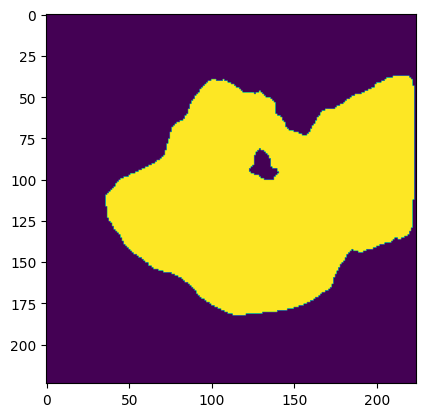

In [25]:
running_vloss = 0.0
acc = 0.0
iou = 0.0
loss_fn = WeightedBinaryCrossEntropyLoss(pos_weight=1.5, neg_weight=1.)
model.eval()
count_labels = 0.0
count_outputs = 0.0

with torch.no_grad():
    for i, vdata in enumerate(val_dataloader):
        vinputs, vlabels = vdata
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        voutputs = torch.round(torch.sigmoid(voutputs))
        plt.imshow(np.array(np.transpose(vinputs[0].cpu(), (1, 2, 0))))
        ##plt.show()
        plt.imshow(np.array(vlabels[0][0].cpu()))
        ##plt.show()
        plt.imshow(np.array(voutputs[0][0].cpu()))
        ##plt.show()
        acc += accuracy(voutputs, vlabels)
        iou += IOU(voutputs, vlabels)
        count_labels += float(vlabels.unique(return_counts = True)[1][1])
        count_outputs += float(voutputs.unique(return_counts = True)[1][1])
        ##print(f"labels = {int(vlabels.unique(return_counts = True)[1][1])}")
        ##print(f"outputs = {voutputs.unique(return_counts = True)[1]}")

count_labels = count_labels / 1066.
count_outputs = count_outputs / 1066.
avg_vloss = running_vloss / (i + 1)
avg_acc = acc / (i + 1)
avg_iou = iou / (i + 1)
print('count_labels {}'.format(count_labels))
print('count_outputs {}'.format(count_outputs))
print('LOSS valid {}'.format(avg_vloss))
print('Average Accuracy valid {}'.format(avg_acc))
print('Average IOU valid {}'.format(avg_iou))

In [26]:
running_vloss = 0.0
acc = 0.0
iou = 0.0
loss_fn = WeightedBinaryCrossEntropyLoss(pos_weight=1.5, neg_weight=1.)
model.eval()
count_labels = 0.0
count_outputs = 0.0

with torch.no_grad():
    for i, vdata in enumerate(train_dataloader):
        vinputs, vlabels = vdata
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        voutputs = torch.round(torch.sigmoid(voutputs))
        acc += accuracy(voutputs, vlabels)
        iou += IOU(voutputs, vlabels)
        count_labels += float(vlabels.unique(return_counts = True)[1][1])
        count_outputs += float(voutputs.unique(return_counts = True)[1][1])
        ##print(f"labels = {int(vlabels.unique(return_counts = True)[1][1])}")
        ##print(f"outputs = {voutputs.unique(return_counts = True)[1]}")

count_labels = count_labels / (i + 1)
count_outputs = count_outputs / (i + 1)
avg_vloss = running_vloss / (i + 1)
avg_acc = acc / (i + 1)
avg_iou = iou / (i + 1)
print('count_labels {}'.format(count_labels))
print('count_outputs {}'.format(count_outputs))
print('LOSS valid {}'.format(avg_vloss))
print('Average Accuracy valid {}'.format(avg_acc))
print('Average IOU valid {}'.format(avg_iou))

count_labels 48667.44370122631
count_outputs 63836.16499442586
LOSS valid 0.43140554428100586
Average Accuracy valid 0.823092491597502
Average IOU valid 0.5161103020311066


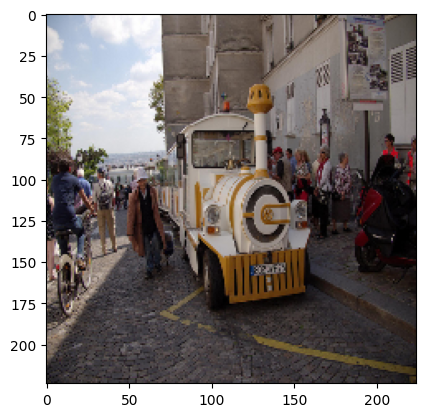

In [9]:
plt.imshow(np.array(np.transpose(vinputs[0].cpu(), (1, 2, 0))))

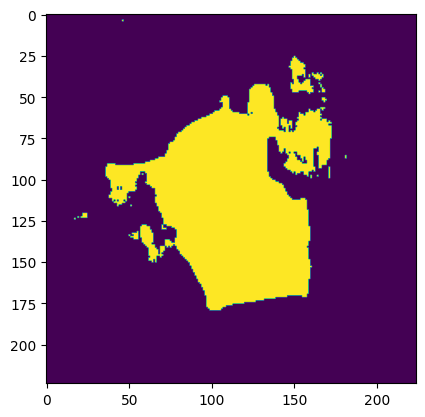

In [10]:
plt.imshow(np.array(voutputs[0][0].cpu()))

In [20]:
running_vloss = 0.0
acc = 0.0
iou = 0.0
loss_fn = WeightedBinaryCrossEntropyLoss(pos_weight=1.5, neg_weight=1.)
model.eval()

with torch.no_grad():
    for i, vdata in enumerate(val_dataloader):
        vinputs, vlabels = vdata
        voutputs = torch.tensor(np.full(vlabels.shape, -5.))
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        vinputs, vlabels, voutputs = vinputs.to(device), vlabels.to(device), voutputs.to(device)
        vloss = loss_fn(voutputs, vlabels)
        voutputs = torch.round(torch.sigmoid(voutputs))
        running_vloss += vloss
        acc += accuracy(voutputs, vlabels) 
        iou += IOU(voutputs, vlabels)

avg_vloss = running_vloss / (i + 1)
avg_acc = acc / (i + 1)
avg_iou = iou / (i + 1)
print('LOSS valid {}'.format(avg_vloss))
print('Average Accuracy valid {}'.format(avg_acc))
print('Average IOU valid {}'.format(avg_iou))

LOSS valid 1.855952501296997
Average Accuracy valid 0.7535453796386719
Average IOU valid 0.0


In [55]:
torch.nonzero(voutputs == 1)

tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)

In [ ]:
voutputs()

In [ ]:
class UNetMobileNetV2fixed(nn.Module):
    """
    U-Net architecture with a fixed MobileNetV2 encoder for image segmentation.

    Args:
    - num_classes (int): Number of output channels/classes for segmentation. Default is 1.

    Attributes:
    - encoder (nn.Module): MobileNetV2 pretrained feature extractor.
    - encoder_layers (list): List of encoder layers for skip connections.
    - classifier (nn.Sequential): Classifier module for the decoder.
    - upsample (nn.Upsample): Upsampling layer.

    Methods:
    - forward(x): Forward pass through the network
    """
    def __init__(self, num_classes=1):
        super(UNetMobileNetV2fixed, self).__init__()

        self.encoder = models.mobilenet_v2(weights='DEFAULT').features

        ## Steps where we will extract the outputs for skip connections, can be changed
        self.encoder_layers = [
            self.encoder[0:2],
            self.encoder[2:4],
            self.encoder[4:7],
            self.encoder[7:14],
            self.encoder[14:19],
            self.encoder[19:24],
            self.encoder[24:],
        ]

        ## The classifier part can be changed; it probably needs to be more complex when the parameters of the pretrained model are fixed
        self.classifier = nn.Sequential(
            nn.Conv2d(320, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, num_classes, height, width).
        """
        # Encoder
        skips = []
        for layer in self.encoder_layers:
            x = layer(x)
            skips.append(x)

        # Decoder
        x = skips[-1]
        for i, skip in enumerate(reversed(skips[:-1])):
            if i > 1:
                x = self.upsample(x)
            x = torch.cat((x, skip), dim=1)

        ## Classifier
        x = self.classifier(x)

        return x


In [ ]:
model = UNetMobileNetV2fixed()

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch
from torch.utils.data import TensorDataset, DataLoader

c:\Users\PC\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
from models import UNetMobileNetV2fixed

In [ ]:
a = UNetMobileNetV2fixed

In [ ]:
b = a()

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
b.encoder

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [ ]:
def filterDataset(folder, classes, annpath, mode, ):    
    # initialize COCO api for instance annotations
    annFile = annpath.format(folder, mode)
    coco = COCO(annFile)
    images = []
    for className in classes:
        # get all images containing given categories
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    
    return unique_images, coco

In [ ]:
images, coco = filterDataset(folder = './COCOdataset2017', classes=['sports ball'], annpath = '{}/annotations/instances_{}2017.json', mode='val')

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [ ]:
len(images)

169

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  


def getTensors(images, classes, coco, folder, mode, input_image_size):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    X = []
    y = []
    for i in range(dataset_size):
        imageObj = images[i]
            
        ### Retrieve Image ###
        img = getImage(imageObj, img_folder, input_image_size)
        img = np.resize(img, (3, input_image_size[0], input_image_size[1]))
        X.append(img)

        ### Create Mask ###
        mask = getMask(imageObj, classes, coco, catIds, input_image_size)
        mask = np.resize(mask, (1, input_image_size[0], input_image_size[1]))
        y.append(mask)
        
    X = torch.Tensor(X)
    y = torch.Tensor(y)
    
    return X, y

In [ ]:
X, y = getTensors(images = images, classes=['sports ball'], coco = coco, folder = './COCOdataset2017', mode ='val', input_image_size=(224,224))

In [ ]:
y[48].shape

torch.Size([1, 224, 224])

In [ ]:
def AugmentData(X, y, p = 0.5, input_image_size=(224,224)):

    n = len(X)
    for i in range(n):
        image = X[i]
        mask = y[i]

        for k in range(3):
            if random.random() < p:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            if random.random() < p:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            if random.random() < p:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            if random.random() < p:
                image = v2.ColorJitter(brightness=random.random())(image)

            if random.random() < p:
                noise = torch.randn(image.size())*0.3 + 0.5
                image = image + noise
                image = v2.ColorJitter(brightness=random.random())(image)
        
            X = torch.cat((X,image.unsqueeze(0)),0)
            y = torch.cat((y,mask.unsqueeze(0)),0)

    return X, y


In [ ]:
X, y = AugmentData(X, y)

In [ ]:
X.shape

torch.Size([676, 3, 224, 224])

In [ ]:
y.shape

torch.Size([676, 1, 224, 224])